In [36]:
!pip install transformers
!pip install pyspellchecker
!pip install Keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import BertTokenizer
from transformers import TFBertModel
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from spellchecker import SpellChecker
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from prettytable import PrettyTable
import time

import warnings
warnings.filterwarnings("ignore")

In [38]:
def calc_precision(y_true, y_pred, average='macro'):
    """
    Calculates the precision score between the true and predicted values
    """
    precision = precision_score(y_true, y_pred, average=average)
    return precision

def calc_recall(y_true, y_pred, average='macro'):
    """
    Calculates the recall score between the true and predicted values
    """
    recall = recall_score(y_true, y_pred, average=average)
    return recall

def calc_f1_score(y_true, y_pred, average='macro'):
    """
    Calculates the f1-score between the true and predicted values
    """
    f1 = f1_score(y_true, y_pred, average=average)
    return f1

def calc_cohen_kappa_score(y_true, y_pred):
    """
    Calculates the cohen kappa score between the true and predicted values
    """
    kappa_score = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
    return kappa_score

def calc_accuracy(y_true, y_pred):
    """
    Calculates the accuracy score between the true and predicted values
    """
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [39]:
def print_metrics_function(y_actual, y_predictions):
    
    # Calculate and print accuracy
    accuracy = calc_accuracy(y_actual, y_predictions)
    print("Accuracy:", accuracy)
    
    # Calculate and print precision
    precision = calc_precision(y_actual, y_predictions)
    print("Precision:", precision)

    # Calculate and print recall
    recall = calc_recall(y_actual, y_predictions)
    print("Recall:", recall)

    # Calculate and print f1-score
    f1 = calc_f1_score(y_actual, y_predictions)
    print("F1-Score:", f1)

    # Calculate and print Cohen Kappa Score
    kappa_score = calc_cohen_kappa_score(y_actual, y_predictions)
    print("Cohen Kappa Score:", kappa_score)

    return accuracy, precision, recall, f1, kappa_score

In [40]:
def choose_classifiers(classifier_name = "logistic_regression"):
    """
    Takes a regressor as input and returns a corresponding classifier object
    """
    
    if classifier_name == 'logistic_regression':
        return LogisticRegression()
    elif classifier_name == 'decision_tree_classifier':
        return DecisionTreeClassifier()
    elif classifier_name == 'random_forest_classifier':
        return RandomForestClassifier()
    elif classifier_name == 'gradient_boosting_classifier':
        return GradientBoostingClassifier()
    elif classifier_name == 'adaboost_classifier':
        return AdaBoostClassifier()
    elif classifier_name == 'k_neighbors_classifier':
        return KNeighborsClassifier()
    elif classifier_name == 'support_vector_classifier':
        return SVC()
    elif classifier_name == 'xgboost_classifier':
        return XGBClassifier()
    elif classifier_name == 'gaussian_naive_bayes_classifier':
        return GaussianNB()
    else:
        raise ValueError(f"Classifier {classifier_name} not supported for this problem.")

In [41]:
def dataset_preparation(data, target = 'domain1_score'):
    
    X = data.drop([target], axis = 1)
    y = data[target]
    
    return X, y

In [42]:
def spell_corrector(tokens):
    spell_checker = SpellChecker()
    correct_tokens = []
    for token in tqdm(tokens):
        if spell_checker.correction(token.lower()):
            correct_tokens.append(spell_checker.correction(token.lower()))
        else:
            correct_tokens.append(token.lower())
    
    return ' '.join(correct_tokens)

In [43]:
# Declaring some visualization methods to plot accuracy and model diagram
def plot_accuracy_curve(history):
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'])
  plt.plot(history.history['mae'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

def plot_acrchitecture(filename, model):
  from keras.utils import plot_model
  plot_model(model, to_file=str(filename) + '.png')

In [44]:
from keras.layers import Embedding, Input, LSTM, Dense, Dropout, Lambda, Flatten, Bidirectional, Conv2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential,Model, load_model, model_from_config
import keras.backend as K

def get_model(Hidden_dim1=400, Hidden_dim2=128, return_sequences = True, dropout=0.2, recurrent_dropout=0.2, input_size=768, activation='relu', bidirectional = False):
    """Define the model."""
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(Hidden_dim1,return_sequences=return_sequences , dropout=0.4, recurrent_dropout=recurrent_dropout), input_shape=[1, input_size]))
        model.add(Bidirectional(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout)))
    else:
        model.add(LSTM(Hidden_dim1, dropout=0.4, recurrent_dropout=recurrent_dropout, input_shape=[1, input_size], return_sequences=return_sequences))
        model.add(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation=activation))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

def get_model_CNN(Hidden_dim1=400, Hidden_dim2=128, return_sequences = True, dropout=0.5, recurrent_dropout=0.4, input_size=768,output_dims=10380, activation='relu', bidirectional = False):
    """Define the model."""
    inputs = Input(shape=(768,1))
    x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)
    #Cuts the size of the output in half, maxing over every 2 inputs
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
    x = GlobalMaxPooling1D()(x) 
    outputs = Dense(output_dims, activation='relu')(x)
    model = Model(inputs=inputs, outputs=outputs, name='CNN')
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mse'])
    model.summary()
    return model

In [45]:
def max_list(a, b):

    if len(a) != len(b):
        raise ValueError("Input lists must have the same length")

    max_list = []
    for i in range(len(a)):
        max_list.append(max(a[i], b[i]))

    return max_list


In [46]:
df = pd.read_csv('/content/drive/MyDrive/Essay Grading Project/Preprocessed_df.csv')
df.head()

essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   rater1_domain1  rater2_domain1  rater3_domain1  domain1_score  \
0               4               4             NaN              8   
1               5               4             NaN              9   
2               4               3             NaN              7   
3               5               5             NaN             10   
4               4               4             NaN              8   

   rater1_domain2  rater2_domain2  domain2_score  ...  word_len  chars_len  \
0             NaN             NaN            NaN  ...       386       1875   
1             NaN             NaN            NaN  ...       464       2288   
2             NaN             NaN            NaN  ...       313       1541   
3             NaN             NaN            NaN  ...       611       3165   
4             NaN             NaN            NaN  ...       517       2569   

   avg_word_length  avg_sentence_length  \
0         3.984456                  1.0   
1         4.030172                  1.0   
2         4.035144                  1.0   
3         4.328969                  1.0   
4         4.071567                  1.0   

                                          pos_ratios  num_sentences  \
0  {'NNP': 0.031088082901554404, 'JJ': 0.05181347...             16   
1  {'NNP': 0.03879310344827586, ',': 0.0258620689...             20   
2  {'NNP': 0.04153354632587859, ',': 0.0287539936...             14   
3  {'NNP': 0.11620294599018004, ',': 0.0212765957...             27   
4  {'NNP': 0.017408123791102514, ',': 0.025145067...             30   

   num_paragraphs  sentiment_polariy  sentiment_subjectivity  \
0               1           0.310471                0.385613   
1               1           0.274000                0.613167   
2               1           0.340393                0.498657   
3               1           0.266828                0.441795   
4               1           0.199684                0.485814   

                                   preprocessed_text  
0  dear local newspaper think effect computer peo...  
1  dear believe using computer benefit u many way...  
2  dear people use computer everyone agrees benef...  
3  dear local newspaper found many expert say com...  
4  dear know computer positive effect people comp...  

[5 rows x 38 columns]

In [47]:
df = df.dropna(axis = 1, how = 'any')
drop_columns = ['essay_id', 'pos_ratios', 'essay', 'rater1_domain1', 'rater2_domain1']
df.drop(drop_columns, axis = 1, inplace = True)


In [48]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')
# df_essay_set = df[df.essay_set == 1]
# X, y = dataset_preparation(df_essay_set)
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 101, test_size = 0.2,)

In [49]:
# # This code can take about 5 - 10 minutes to run depending on the speed of the system
# BATCH_SIZE = 16
# MAX_LENGTH = 300

# train_encodings = tokenizer(list(X_train['preprocessed_text']), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
# train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(BATCH_SIZE)

# test_encodings = tokenizer(list(X_test['preprocessed_text']), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
# test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(BATCH_SIZE)

# embeddings_train = []
# for batch in tqdm(train_dataset):
#     embeddings_train.append(bert_model(batch[0]['input_ids'])[0][:, -1, :])
# embeddings_train = tf.concat(embeddings_train, axis=0)

# embeddings_test = []
# for batch in tqdm(test_dataset):
#     embeddings_test.append(bert_model(batch[0]['input_ids'])[0][:, -1, :])
# embeddings_test = tf.concat(embeddings_test, axis=0)

In [50]:
# from google.colab import drive
# drive.mount('/content/drive')

In [51]:
# ###CNN
# trainDataVectors=tf.reshape(embeddings_train,[embeddings_train.shape[0],1,embeddings_train.shape[1]])
# testDataVectors=tf.reshape(embeddings_test,[embeddings_test.shape[0],1,embeddings_test.shape[1]])
# trainDataVectors_=tf.reshape(trainDataVectors,[trainDataVectors.shape[0],trainDataVectors.shape[2],1])
# testDataVectors_=tf.reshape(testDataVectors,[testDataVectors.shape[0],testDataVectors.shape[2],1])
# cnn = get_model_CNN(output_dims=1)
# cnn.fit(trainDataVectors_, y_train, batch_size=128, epochs=100)
# y_pred = cnn.predict(testDataVectors_)
# y_pred = np.around(y_pred)
# np.nan_to_num(y_pred)

# print_metrics_function(y_test, y_pred)


In [52]:
# embeddings_train.shape

 -------------------------------------------------
 -------------------------------------------------

--------SET 1--------

 -------------------------------------------------
 -------------------------------------------------

--------Fold 1--------



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.96it/s]


-----------------------LSTM-----------------------


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 400)            1870400   
                                                                 
 lstm_5 (LSTM)               (None, 128)               270848    
                                                                 
 dropout_187 (Dropout)       (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 16ms/step - loss: 18.1758 - mae: 3.0205
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 2.5677 -

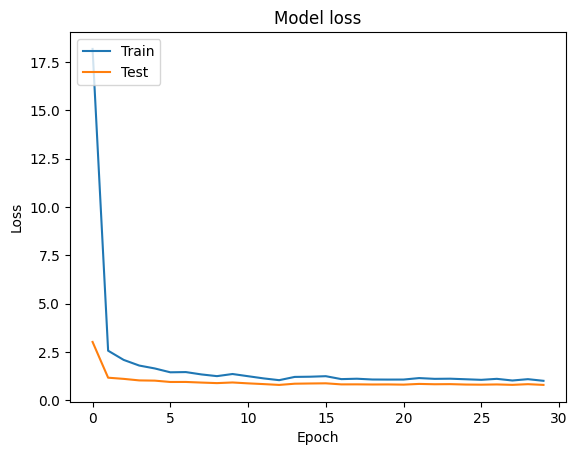

Accuracy: 0.38095238095238093
Precision: 0.2423286419143026
Recall: 0.18081971555602389
F1-Score: 0.16257637181875664
Cohen Kappa Score: 0.708257088152382
-----------------------BiLSTM-----------------------


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 1, 600)           2565600   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              560800    
 nal)                                                            
                                                                 
 dropout_188 (Dropout)       (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==========================

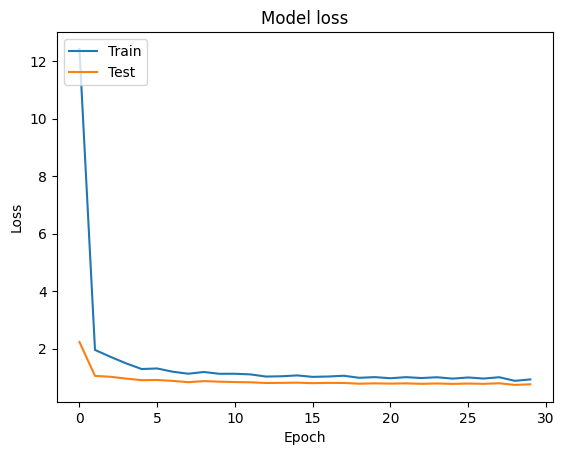

Accuracy: 0.45938375350140054
Precision: 0.30291781387198835
Recall: 0.24663104531258692
F1-Score: 0.2531572682636512
Cohen Kappa Score: 0.7840781928647746
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 768, 64)           256       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 384, 64)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              

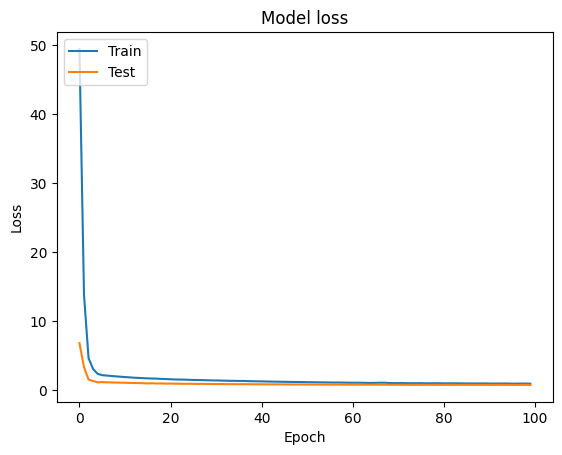

Accuracy: 0.47619047619047616
Precision: 0.27471120953699535
Recall: 0.26432386747802566
F1-Score: 0.2611273874460817
Cohen Kappa Score: 0.7534048615560797

-----------------------Logistic Regression-----------------------
Accuracy: 0.5154061624649859
Precision: 0.3980033975686149
Recall: 0.38811149747255225
F1-Score: 0.3580457004733325
Cohen Kappa Score: 0.7600806451612904


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5322128851540616
Precision: 0.3954910317086483
Recall: 0.4410176599375383
F1-Score: 0.3936874173201601
Cohen Kappa Score: 0.7664811204596758


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.4789915966386555
Precision: 0.19289743589743588
Recall: 0.22031746031746033
F1-Score: 0.18486704270749393
Cohen Kappa Score: 0.6345546361377612


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.484593837535014
Precision: 0.34295112638411607
Recall: 0.2861249557294182
F1-Score: 0.30008

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.93it/s]


-----------------------LSTM-----------------------


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 400)            1870400   
                                                                 
 lstm_9 (LSTM)               (None, 128)               270848    
                                                                 
 dropout_226 (Dropout)       (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 15ms/step - loss: 20.3197 - mae: 3.2741
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 2.8650 -

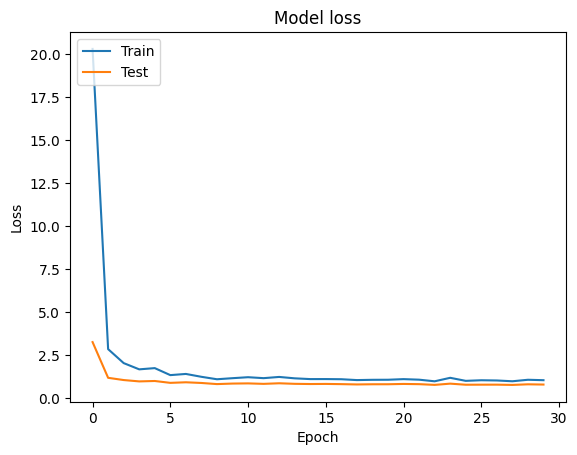

Accuracy: 0.226890756302521
Precision: 0.09232899006518881
Recall: 0.13039544534675399
F1-Score: 0.0953590527119939
Cohen Kappa Score: 0.6492104737157705
-----------------------BiLSTM-----------------------


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 1, 600)           2565600   
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 200)              560800    
 nal)                                                            
                                                                 
 dropout_227 (Dropout)       (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==========================

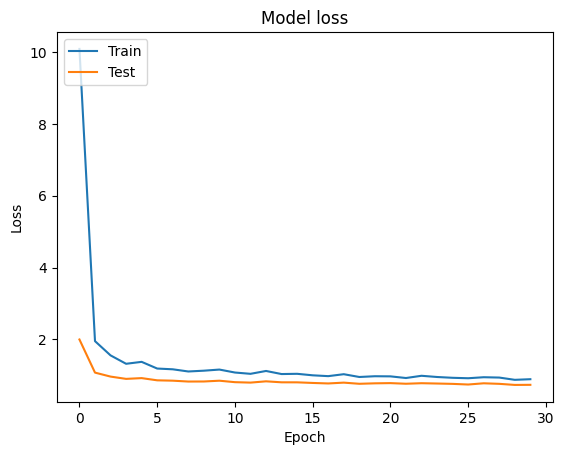

Accuracy: 0.47619047619047616
Precision: 0.4171622617857324
Recall: 0.29701086152225004
F1-Score: 0.32720858101586164
Cohen Kappa Score: 0.8073631718278643
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_10 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 384, 64)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              

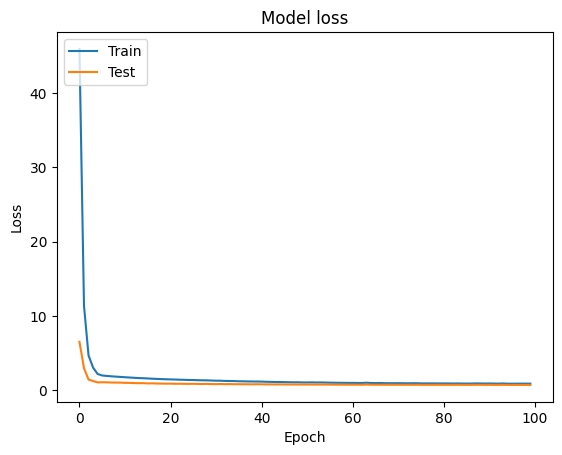

Accuracy: 0.4789915966386555
Precision: 0.3011123609548806
Recall: 0.29411695437814933
F1-Score: 0.2929855461796234
Cohen Kappa Score: 0.7785837374263616

-----------------------Logistic Regression-----------------------
Accuracy: 0.484593837535014
Precision: 0.47350483206163024
Recall: 0.39948342805143305
F1-Score: 0.4183290309650703
Cohen Kappa Score: 0.7857194899817851


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5042016806722689
Precision: 0.5172975129445717
Recall: 0.3905467064683181
F1-Score: 0.4118995246369259
Cohen Kappa Score: 0.7634478289047311


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.46218487394957986
Precision: 0.19038424468290177
Recall: 0.27331243972999036
F1-Score: 0.21793214414514384
Cohen Kappa Score: 0.6187363834422658


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.49299719887955185
Precision: 0.4103759316360837
Recall: 0.3790518326933636
F1-Score: 0.37270

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.98it/s]


-----------------------LSTM-----------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_13 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_265 (Dropout)       (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 16ms/step - loss: 19.3883 - mae: 3.1602
Epoch 2/30
12/12 [============

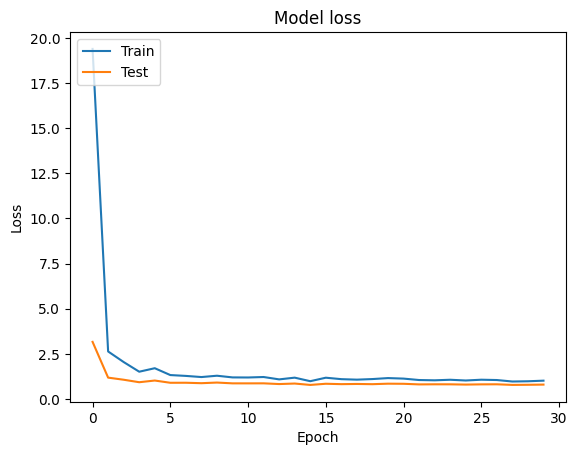

Accuracy: 0.43137254901960786
Precision: 0.3476403166725747
Recall: 0.40788459837225766
F1-Score: 0.34758274577677073
Cohen Kappa Score: 0.7582821143518921
-----------------------BiLSTM-----------------------


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 1, 600)           2565600   
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 200)              560800    
 nal)                                                            
                                                                 
 dropout_266 (Dropout)       (None, 200)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==========================

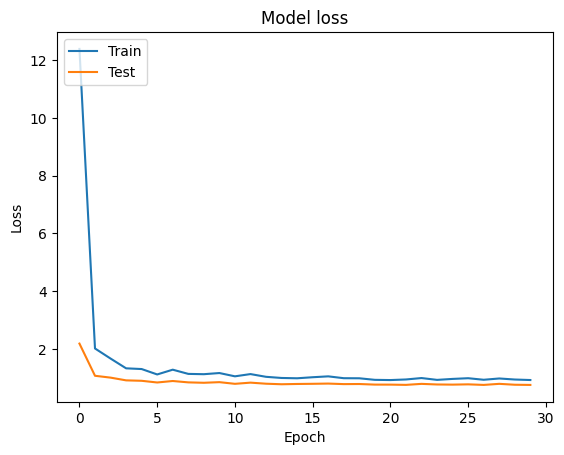

Accuracy: 0.24369747899159663
Precision: 0.21679387259882618
Recall: 0.2221634471037337
F1-Score: 0.19103338290178937
Cohen Kappa Score: 0.6528260741439265
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 384, 64)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              

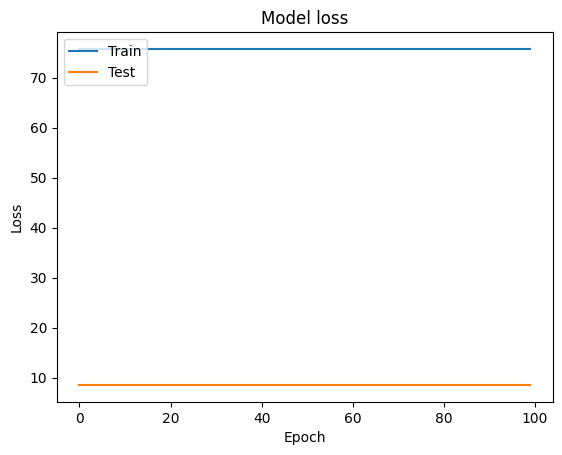

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.47619047619047616
Precision: 0.21471457439412844
Recall: 0.19721800006433765
F1-Score: 0.2003447026293282
Cohen Kappa Score: 0.7491078989633524


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5182072829131653
Precision: 0.3379170186143203
Recall: 0.25880728731047203
F1-Score: 0.28023969182131114
Cohen Kappa Score: 0.7432967829854498


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.4649859943977591
Precision: 0.07884003092601498
Recall: 0.1474015634047481
F1-Score: 0.09990499590499592
Cohen Kappa Score: 0.5535087373279161


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.48739495798319327
Precision: 0.3278881945844252
Recall: 0.3024073001780008
F1-Score: 0.3077322343479331
Cohen Kappa Score: 0.7030110833365073


----------------------

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.92it/s]


-----------------------LSTM-----------------------


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_17 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_304 (Dropout)       (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 15ms/step - loss: 18.9811 - mae: 3.1071
Epoch 2/30
12/12 [==============================] - 0s 16ms/step - loss: 2.6089 -

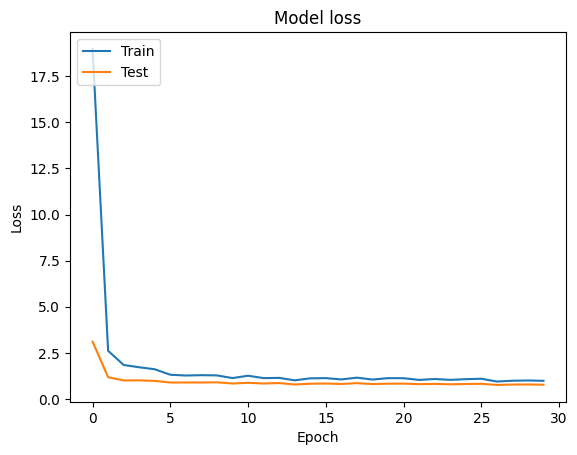

Accuracy: 0.3848314606741573
Precision: 0.3086283628713675
Recall: 0.26455639827615635
F1-Score: 0.2649040559683704
Cohen Kappa Score: 0.8068396233604321
-----------------------BiLSTM-----------------------


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 1, 600)           2565600   
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 200)              560800    
 nal)                                                            
                                                                 
 dropout_305 (Dropout)       (None, 200)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==========================

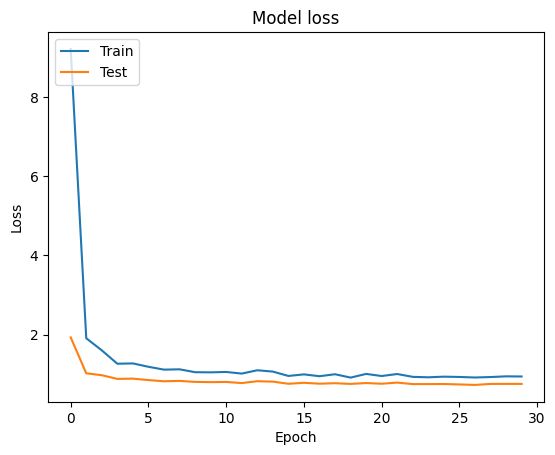

Accuracy: 0.43258426966292135
Precision: 0.41736221858710415
Recall: 0.34861023832798027
F1-Score: 0.35837427193818167
Cohen Kappa Score: 0.7931456675347852
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_14 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 384, 64)          0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)             

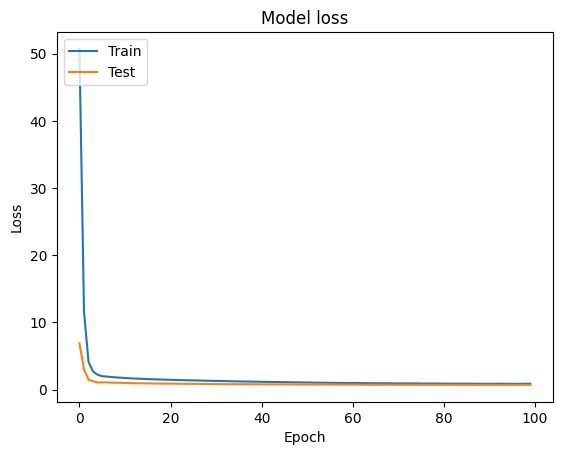

Accuracy: 0.42696629213483145
Precision: 0.24487772960309423
Recall: 0.25431323604710704
F1-Score: 0.24610435478554452
Cohen Kappa Score: 0.7215299506089996

-----------------------Logistic Regression-----------------------
Accuracy: 0.43820224719101125
Precision: 0.3758750601250601
Recall: 0.3241714669738863
F1-Score: 0.32499938555623675
Cohen Kappa Score: 0.7981268749542694


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.45224719101123595
Precision: 0.46790354767184034
Recall: 0.3544260432667691
F1-Score: 0.3526650543483404
Cohen Kappa Score: 0.7853631972389796


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.45224719101123595
Precision: 0.18817033678756476
Recall: 0.26285714285714284
F1-Score: 0.21337331334332835
Cohen Kappa Score: 0.6417667429808829


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.3960674157303371
Precision: 0.27611692393424014
Recall: 0.2577641769073221
F1-Score: 0

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.96it/s]


-----------------------LSTM-----------------------


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_21 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_343 (Dropout)       (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 17ms/step - loss: 19.1542 - mae: 3.1488
Epoch 2/30
12/12 [==============================] - 0s 17ms/step - loss: 2.4816 

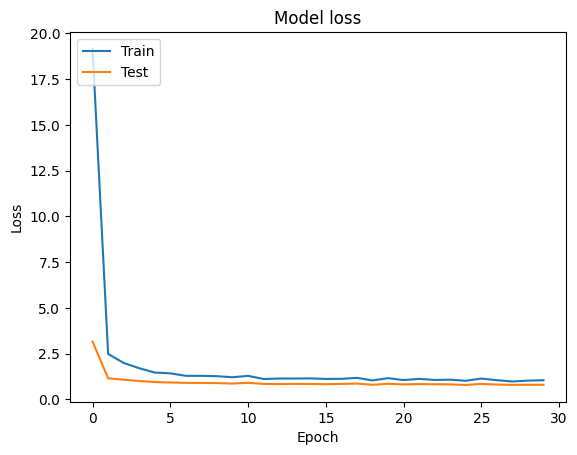

Accuracy: 0.46629213483146065
Precision: 0.3078507535713635
Recall: 0.29010768772995604
F1-Score: 0.2797416239250244
Cohen Kappa Score: 0.7904606997764458
-----------------------BiLSTM-----------------------


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_344 (Dropout)       (None, 200)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

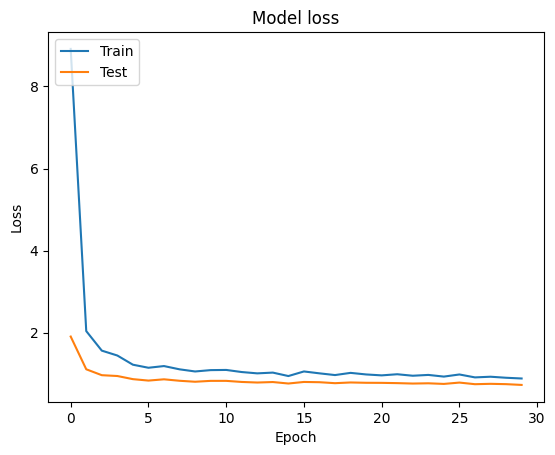

Accuracy: 0.3651685393258427
Precision: 0.4081031405568903
Recall: 0.27797839284344295
F1-Score: 0.30392537388536545
Cohen Kappa Score: 0.7148827041116623
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 384, 64)          0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 128)              0

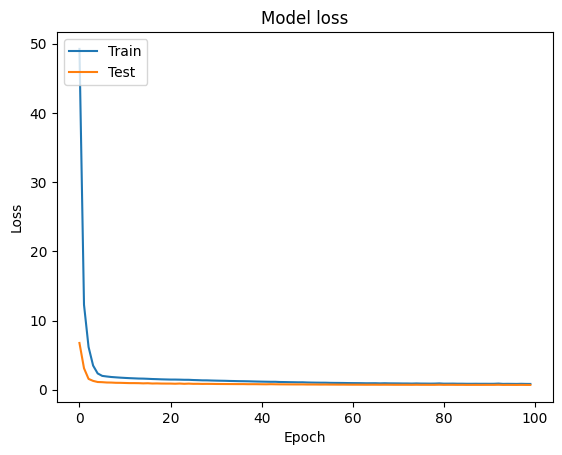

Accuracy: 0.46348314606741575
Precision: 0.2748444876293967
Recall: 0.3015001538541219
F1-Score: 0.27019264839482415
Cohen Kappa Score: 0.7216955773779657

-----------------------Logistic Regression-----------------------
Accuracy: 0.5
Precision: 0.3795005865330808
Recall: 0.35254219817426435
F1-Score: 0.35918736528399575
Cohen Kappa Score: 0.7465523309762263


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5028089887640449
Precision: 0.3871050824175824
Recall: 0.34171970317833167
F1-Score: 0.35169241084555247
Cohen Kappa Score: 0.7208632237446027


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.4803370786516854
Precision: 0.1921239636794315
Recall: 0.2608787050662182
F1-Score: 0.21589595375722545
Cohen Kappa Score: 0.6293867933013149


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.4101123595505618
Precision: 0.2446928563754947
Recall: 0.2503958570080806
F1-Score: 0.24185881530578376
Co

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:10<00:00,  2.25it/s]


-----------------------LSTM-----------------------
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_25 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_382 (Dropout)       (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 18ms/step - loss: 2.5284 - mae: 1.1558
Epoch 2/30
12/12 [============

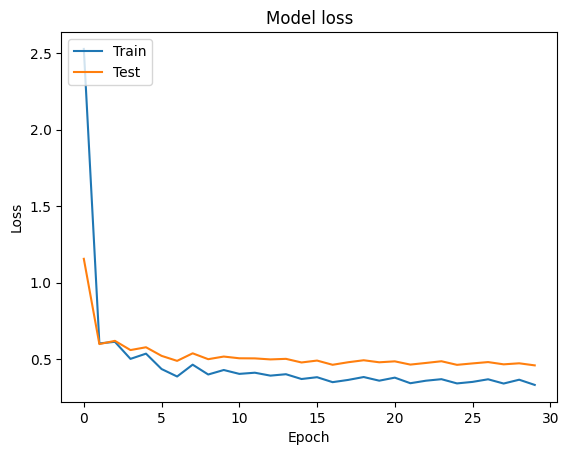

Accuracy: 0.6083333333333333
Precision: 0.39581070270725444
Recall: 0.37923936594822666
F1-Score: 0.38395555227769995
Cohen Kappa Score: 0.6028037383177571
-----------------------BiLSTM-----------------------


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_383 (Dropout)       (None, 200)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

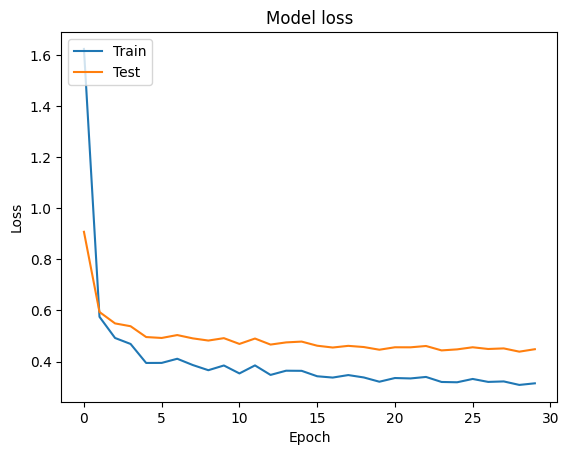

Accuracy: 0.6416666666666667
Precision: 0.4278822825729013
Recall: 0.3856787166913749
F1-Score: 0.39903530377668306
Cohen Kappa Score: 0.6175867888138862
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_18 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 384, 64)          0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 128)              0 

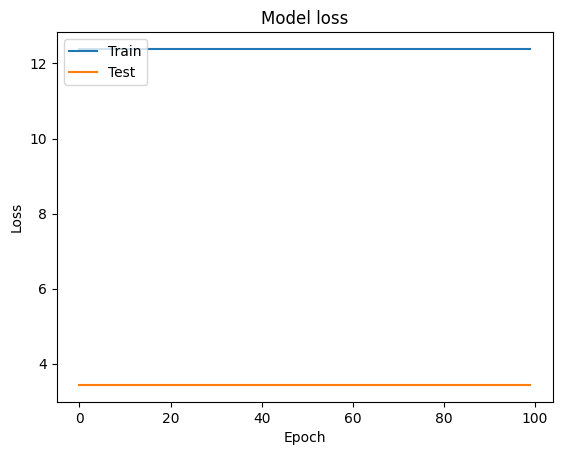

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.6472222222222223
Precision: 0.5764051565377533
Recall: 0.43911316379670806
F1-Score: 0.47710880463691374
Cohen Kappa Score: 0.6465683905268246


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.6472222222222223
Precision: 0.49230028160663997
Recall: 0.40873911886570113
F1-Score: 0.43055116716848163
Cohen Kappa Score: 0.6458409008354522


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.6527777777777778
Precision: 0.38518618508130215
Recall: 0.3886380050937013
F1-Score: 0.3854764866145463
Cohen Kappa Score: 0.6379882092851878


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.6138888888888889
Precision: 0.4584173800039551
Recall: 0.3935492454479796
F1-Score: 0.4138522867482541
Cohen Kappa Score: 0.5965103598691386


-----------------------S

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.93it/s]


-----------------------LSTM-----------------------
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_29 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_421 (Dropout)       (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 27ms/step - loss: 2.8241 - mae: 1.1894
Epoch 2/30
12/12 [============

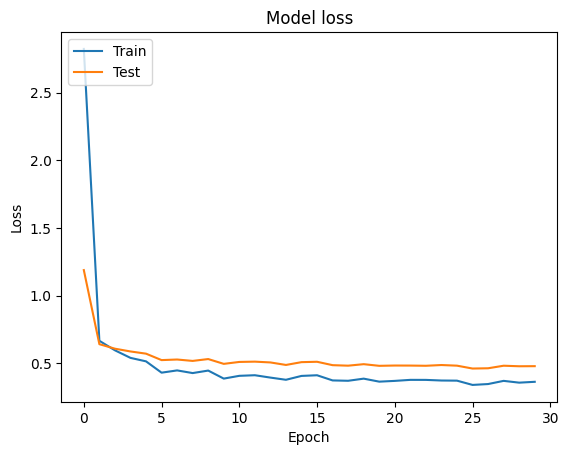

Accuracy: 0.6722222222222223
Precision: 0.33927617114831726
Recall: 0.3333509205458715
F1-Score: 0.333293583304393
Cohen Kappa Score: 0.597194862500985
-----------------------BiLSTM-----------------------


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_422 (Dropout)       (None, 200)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

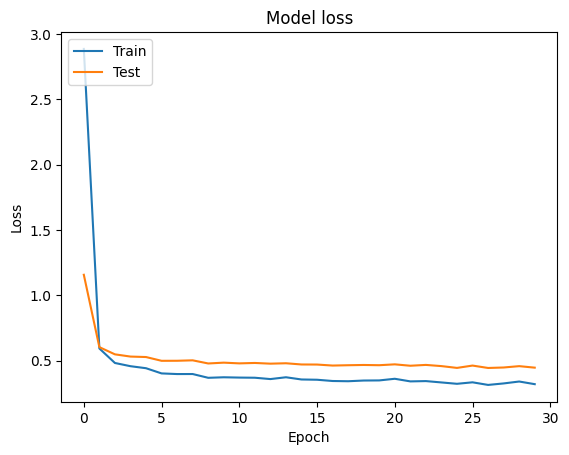

Accuracy: 0.6861111111111111
Precision: 0.3999850526851784
Recall: 0.37281031783135576
F1-Score: 0.3830678528639147
Cohen Kappa Score: 0.6461053579468707
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_20 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_10 (Gl  (None, 128)              0 

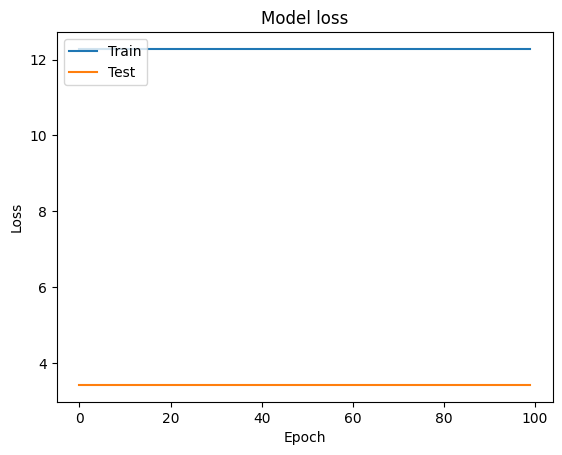

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.6972222222222222
Precision: 0.4610791682937713
Recall: 0.40395452555340355
F1-Score: 0.41729417601759106
Cohen Kappa Score: 0.6978018069289322


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.6916666666666667
Precision: 0.47152440850554056
Recall: 0.4013955490252825
F1-Score: 0.42483885608756494
Cohen Kappa Score: 0.6759305565478317


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.6694444444444444
Precision: 0.3151205193615908
Recall: 0.36050223736058234
F1-Score: 0.3313344659549329
Cohen Kappa Score: 0.642570554233254


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.6666666666666666
Precision: 0.4460655737704918
Recall: 0.3702239586811817
F1-Score: 0.3949416948254158
Cohen Kappa Score: 0.6254980079681275


-----------------------Sup

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.91it/s]


-----------------------LSTM-----------------------


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_33 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_460 (Dropout)       (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 18ms/step - loss: 2.5106 - mae: 1.1506
Epoch 2/30
12/12 [==============================] - 0s 17ms/step - loss: 0.6738 -

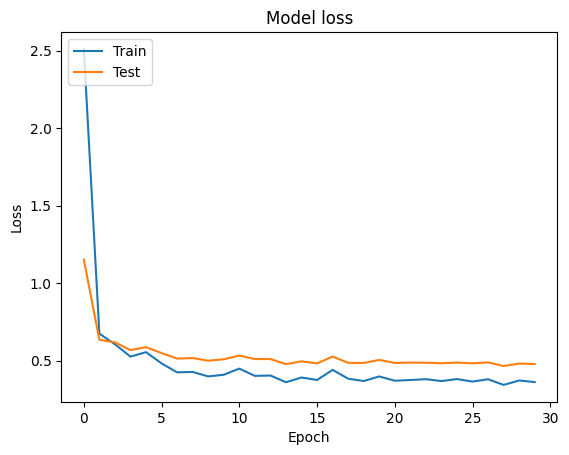

Accuracy: 0.6777777777777778
Precision: 0.5059856863310358
Recall: 0.47447116777745574
F1-Score: 0.4876311174876455
Cohen Kappa Score: 0.6730031391698639
-----------------------BiLSTM-----------------------


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_461 (Dropout)       (None, 200)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

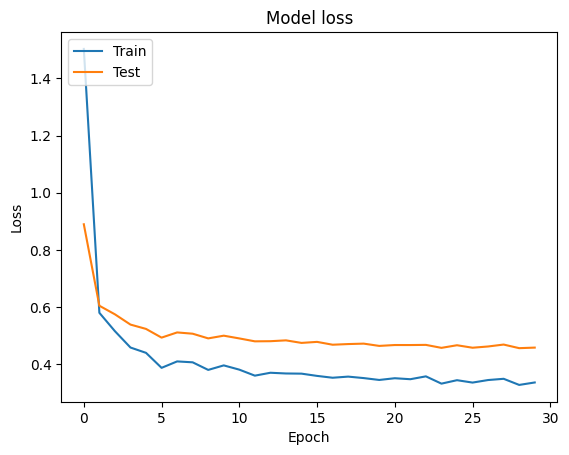

Accuracy: 0.675
Precision: 0.4324344941956882
Recall: 0.37874194770746494
F1-Score: 0.3868377668678116
Cohen Kappa Score: 0.6429302391485745
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_22 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_11 (Gl  (None, 128)              0         
 oba

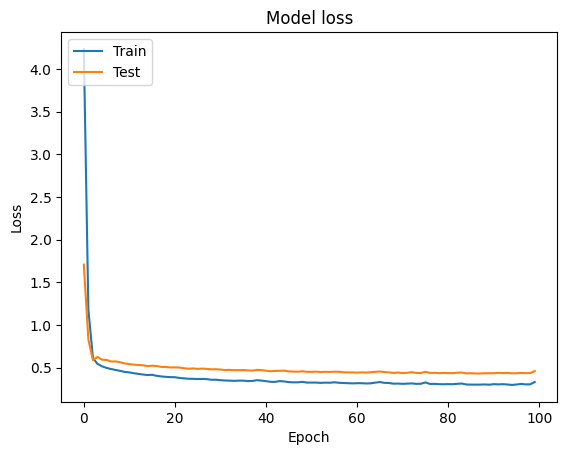

Accuracy: 0.6833333333333333
Precision: 0.3179589581123954
Recall: 0.33460498257658494
F1-Score: 0.32605797730065783
Cohen Kappa Score: 0.6490258843410299

-----------------------Logistic Regression-----------------------
Accuracy: 0.7333333333333333
Precision: 0.6146720443778502
Recall: 0.5061219713349531
F1-Score: 0.5447793743587191
Cohen Kappa Score: 0.6799288730829074


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.7194444444444444
Precision: 0.5135627373479036
Recall: 0.38888152077807253
F1-Score: 0.41275452166988974
Cohen Kappa Score: 0.6839514276337382


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.6444444444444445
Precision: 0.2897183214256385
Recall: 0.3322671243563739
F1-Score: 0.30187756604989413
Cohen Kappa Score: 0.6380980334605224


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.6666666666666666
Precision: 0.4992538818310143
Recall: 0.4494291881208716
F1-Score: 0.4698618

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.95it/s]


-----------------------LSTM-----------------------


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_37 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_499 (Dropout)       (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 18ms/step - loss: 3.2713 - mae: 1.2907
Epoch 2/30
12/12 [==============================] - 0s 19ms/step - loss: 0.6475 -

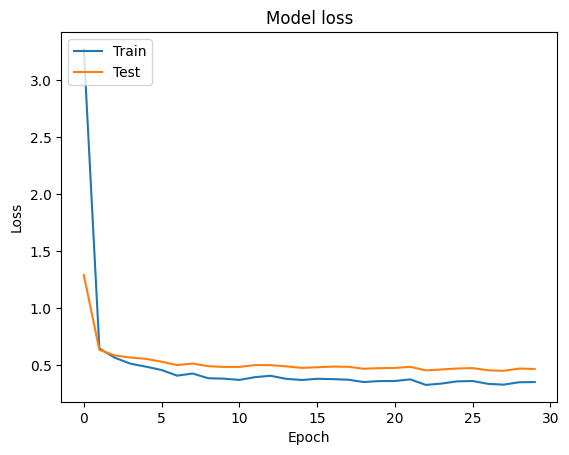

Accuracy: 0.5555555555555556
Precision: 0.3886246668504733
Recall: 0.358337314859054
F1-Score: 0.34710289710289716
Cohen Kappa Score: 0.4757767633632749
-----------------------BiLSTM-----------------------


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_500 (Dropout)       (None, 200)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

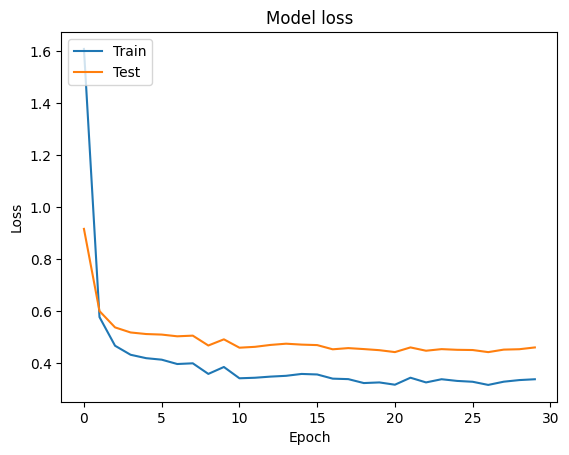

Accuracy: 0.5972222222222222
Precision: 0.44782670775788375
Recall: 0.40967506728376296
F1-Score: 0.40567498516323147
Cohen Kappa Score: 0.5764394440767704
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_24 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_12 (Gl  (None, 128)              

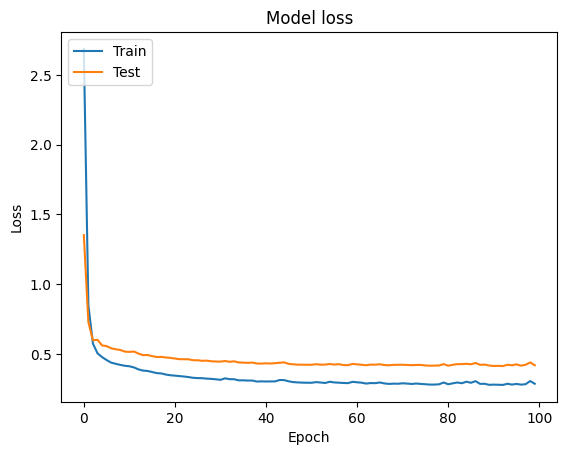

Accuracy: 0.5944444444444444
Precision: 0.30871595401298374
Recall: 0.299729457338153
F1-Score: 0.3010289899494445
Cohen Kappa Score: 0.5361567271679631

-----------------------Logistic Regression-----------------------
Accuracy: 0.6666666666666666
Precision: 0.4092803046535081
Recall: 0.3465040394388221
F1-Score: 0.3633171391051196
Cohen Kappa Score: 0.6420338983050847


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.6333333333333333
Precision: 0.3846546546546547
Recall: 0.3865729680947072
F1-Score: 0.36132501694026287
Cohen Kappa Score: 0.6148531181741185


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.6361111111111111
Precision: 0.3101643720676141
Recall: 0.31994836886141237
F1-Score: 0.3128063989571613
Cohen Kappa Score: 0.5945044684540484


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.6222222222222222
Precision: 0.4238595523972883
Recall: 0.3156619447380317
F1-Score: 0.3328501286

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:07<00:00,  2.97it/s]


-----------------------LSTM-----------------------
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_41 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_538 (Dropout)       (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 17ms/step - loss: 2.4074 - mae: 1.1257
Epoch 2/30
12/12 [============

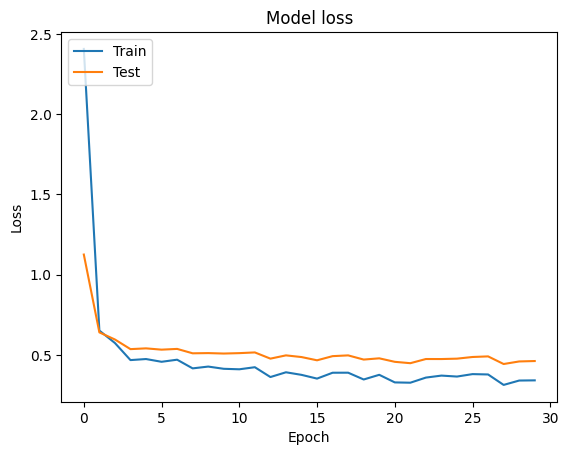

Accuracy: 0.6527777777777778
Precision: 0.3402923948632904
Recall: 0.3322255205644467
F1-Score: 0.3313713181204347
Cohen Kappa Score: 0.5909732016925247
-----------------------BiLSTM-----------------------


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_539 (Dropout)       (None, 200)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

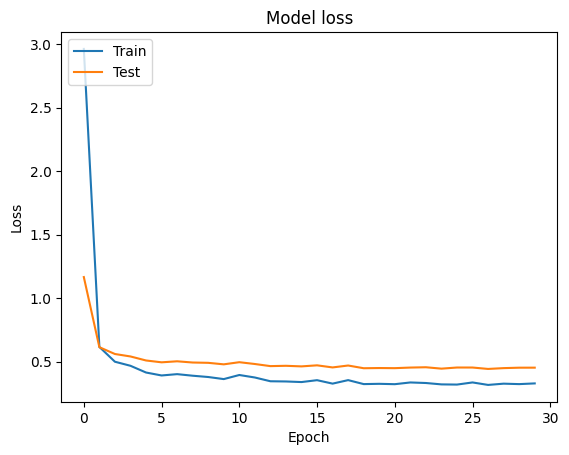

Accuracy: 0.6305555555555555
Precision: 0.4895382769876697
Recall: 0.33015688636494006
F1-Score: 0.3343208634078201
Cohen Kappa Score: 0.5710681244743483
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_26 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_13 (Gl  (None, 128)              0 

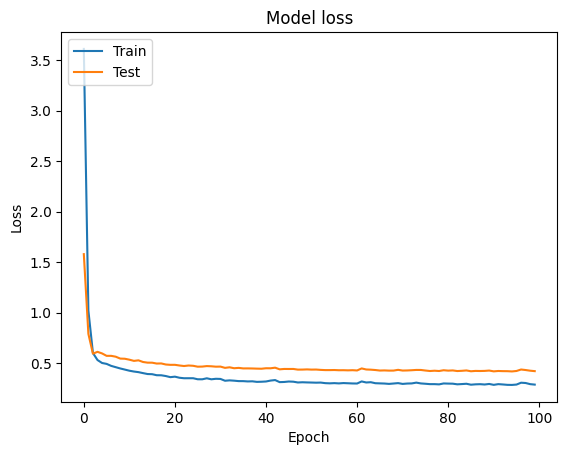

Accuracy: 0.6305555555555555
Precision: 0.4864783865735844
Recall: 0.34200940744564906
F1-Score: 0.348414901548242
Cohen Kappa Score: 0.5776980402980956

-----------------------Logistic Regression-----------------------
Accuracy: 0.6722222222222223
Precision: 0.43132158648106117
Recall: 0.3640616933402168
F1-Score: 0.3711052952265573
Cohen Kappa Score: 0.6332749089928542


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.6472222222222223
Precision: 0.329982973404026
Recall: 0.34219225032983425
F1-Score: 0.3350444471648686
Cohen Kappa Score: 0.6035788024776325


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.6222222222222222
Precision: 0.28128264752468574
Recall: 0.2794914816726897
F1-Score: 0.27532742056904125
Cohen Kappa Score: 0.5170332039672272


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.625
Precision: 0.5736221202428963
Recall: 0.42512404634887857
F1-Score: 0.4706800930667057
Cohe

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 22/22 [00:05<00:00,  4.30it/s]


-----------------------LSTM-----------------------


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_45 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_577 (Dropout)       (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 6s 19ms/step - loss: 1.2519 - mae: 0.8793
Epoch 2/30
11/11 [==============================] - 0s 20ms/step - loss: 0.5919 -

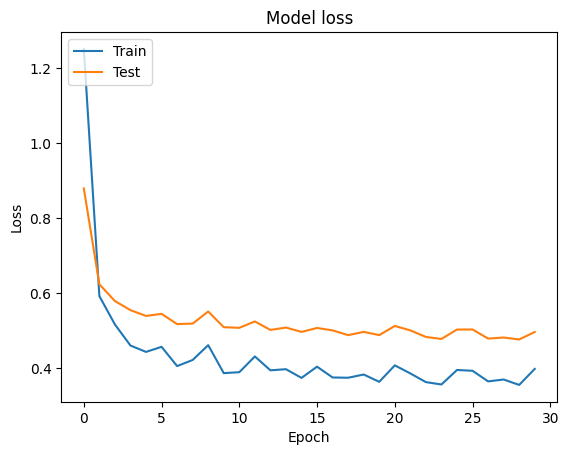

Accuracy: 0.5780346820809249
Precision: 0.518607713217805
Recall: 0.4147802167756493
F1-Score: 0.40101613069105446
Cohen Kappa Score: 0.543015634544584
-----------------------BiLSTM-----------------------


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_578 (Dropout)       (None, 200)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [=========================

Accuracy: 0.5433526011560693
Precision: 0.4851109851835471
Recall: 0.397054231327132
F1-Score: 0.38687138767352675
Cohen Kappa Score: 0.4845667977595042
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_28 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_14 (Gl  (None, 128)              0  

Accuracy: 0.02023121387283237
Precision: 0.0050578034682080926
Recall: 0.25
F1-Score: 0.009915014164305949
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.5722543352601156
Precision: 0.4168532754010695
Recall: 0.44978177092926874
F1-Score: 0.3967744960131592
Cohen Kappa Score: 0.6095829926410465


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5289017341040463
Precision: 0.4625233015741508
Recall: 0.406205030277215
F1-Score: 0.3943070445958602
Cohen Kappa Score: 0.46130966212762003


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.5867052023121387
Precision: 0.44618638385908793
Recall: 0.441329261834592
F1-Score: 0.43709509966777416
Cohen Kappa Score: 0.5172052379689611


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.6329479768786127
Precision: 0.47491666666666665
Recall: 0.48789738844630687
F1-Score: 0.48080608456102525
Cohen Kappa S

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 22/22 [00:10<00:00,  2.15it/s]


-----------------------LSTM-----------------------


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_49 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_616 (Dropout)       (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 6s 19ms/step - loss: 1.1042 - mae: 0.8263
Epoch 2/30
11/11 [==============================] - 0s 18ms/step - loss: 0.7073 -

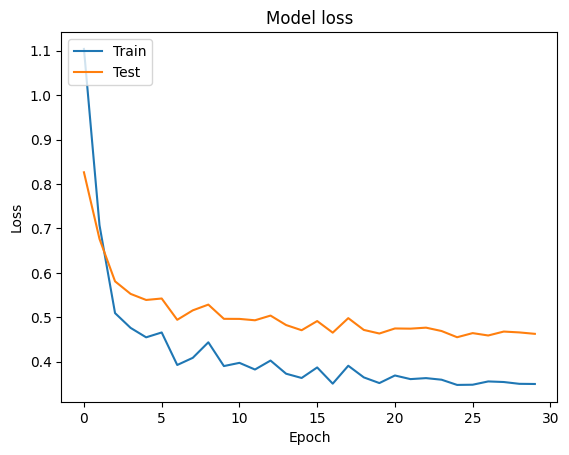

Accuracy: 0.3710144927536232
Precision: 0.41297633457155974
Recall: 0.28509652140672787
F1-Score: 0.20066148378543391
Cohen Kappa Score: 0.3485760206981712
-----------------------BiLSTM-----------------------


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_24 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_617 (Dropout)       (None, 200)               0         
                                                                 
 dense_40 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [=========================

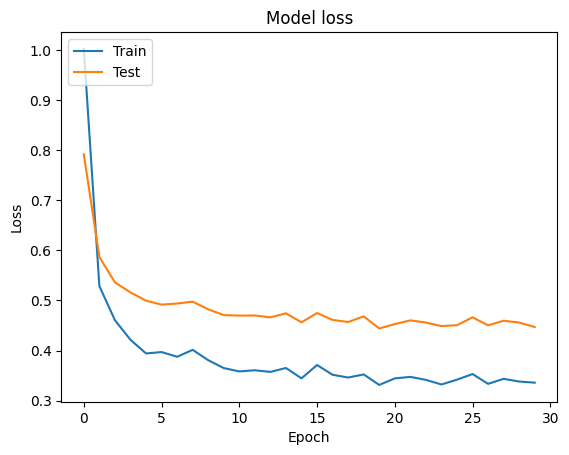

Accuracy: 0.3188405797101449
Precision: 0.32991202346041054
Recall: 0.2526041666666667
F1-Score: 0.12626575028636886
Cohen Kappa Score: 0.020773738439747946
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_30 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_15 (Gl  (None, 128)             

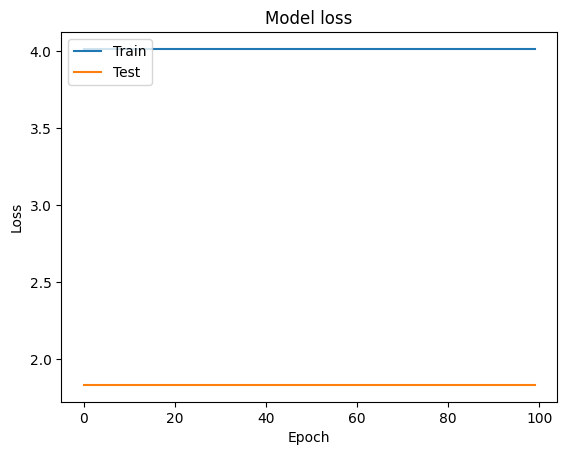

Accuracy: 0.02318840579710145
Precision: 0.005797101449275362
Recall: 0.25
F1-Score: 0.0113314447592068
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.3652173913043478
Precision: 0.3822872837774661
Recall: 0.29000946969696967
F1-Score: 0.2003523636809494
Cohen Kappa Score: 0.16879780829408042


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.391304347826087
Precision: 0.5964912280701754
Recall: 0.2575019113149847
F1-Score: 0.15399004250722154
Cohen Kappa Score: 0.02568249293972813


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.43768115942028984
Precision: 0.5471774193548387
Recall: 0.4490612837086461
F1-Score: 0.3207998530055895
Cohen Kappa Score: 0.43570678608926694


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5971014492753624
Precision: 0.4851395464595367
Recall: 0.44782327286627743
F1-Score: 0.4474364791288566
Cohen Kappa Sco

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 22/22 [00:10<00:00,  2.15it/s]


-----------------------LSTM-----------------------
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_53 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_655 (Dropout)       (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 6s 33ms/step - loss: 1.1684 - mae: 0.8512
Epoch 2/30
11/11 [============

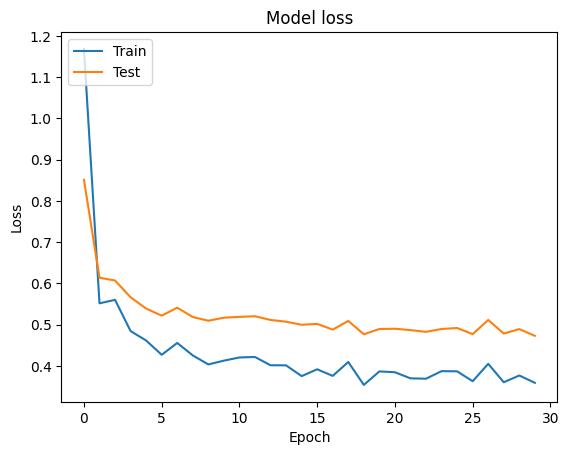

Accuracy: 0.4753623188405797
Precision: 0.40040315771698753
Recall: 0.3959104938271605
F1-Score: 0.35164724892447663
Cohen Kappa Score: 0.49631782945736425
-----------------------BiLSTM-----------------------


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_26 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_27 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_656 (Dropout)       (None, 200)               0         
                                                                 
 dense_43 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [=========================

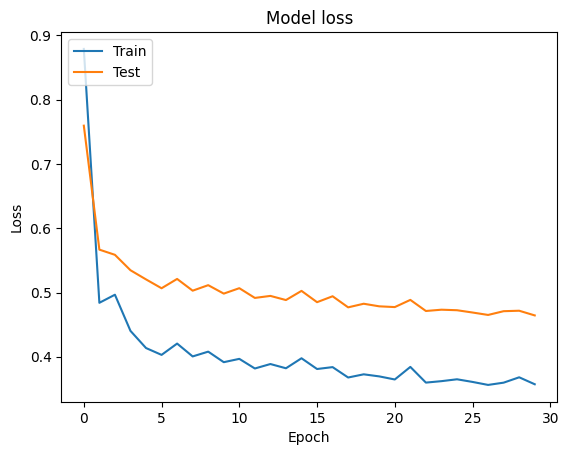

Accuracy: 0.5478260869565217
Precision: 0.44512098885193396
Recall: 0.4209104938271605
F1-Score: 0.4152319998045525
Cohen Kappa Score: 0.5437013721100348
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_32 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_16 (Gl  (None, 128)              0 

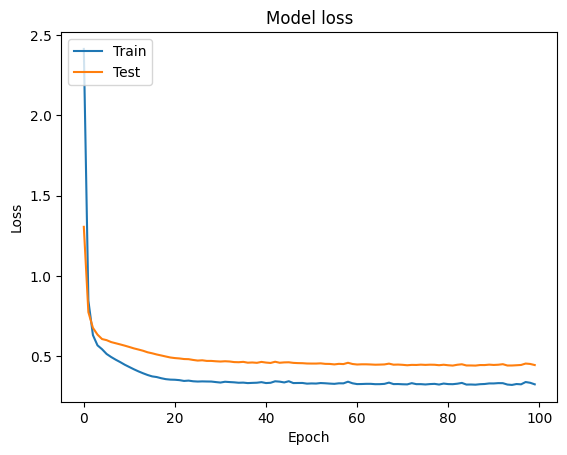

Accuracy: 0.40869565217391307
Precision: 0.31815652818991097
Recall: 0.2697530864197531
F1-Score: 0.18127499523900212
Cohen Kappa Score: 0.06720741599072999

-----------------------Logistic Regression-----------------------
Accuracy: 0.553623188405797
Precision: 0.4944088965204433
Recall: 0.41242283950617287
F1-Score: 0.4078720204424714
Cohen Kappa Score: 0.49556258288279087


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.40869565217391307
Precision: 0.3196862635061802
Recall: 0.33796296296296297
F1-Score: 0.3133527265995159
Cohen Kappa Score: 0.4116785806562743


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.39420289855072466
Precision: 0.37164861328195997
Recall: 0.3667438271604938
F1-Score: 0.2883327692290425
Cohen Kappa Score: 0.35464211148791347


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5594202898550724
Precision: 0.5669668192817228
Recall: 0.4761574074074074
F1-Score: 0.50

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 22/22 [00:04<00:00,  5.11it/s]


-----------------------LSTM-----------------------


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_57 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_694 (Dropout)       (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 7s 23ms/step - loss: 1.3173 - mae: 0.9019
Epoch 2/30
11/11 [==============================] - 0s 20ms/step - loss: 0.5868 -

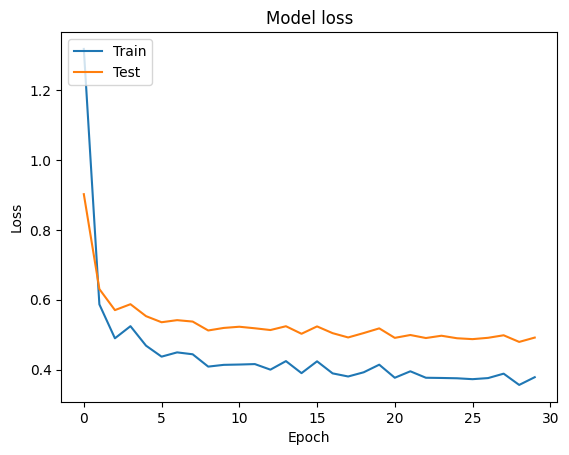

Accuracy: 0.5652173913043478
Precision: 0.2949204495694059
Recall: 0.3676402877697842
F1-Score: 0.3228413654618474
Cohen Kappa Score: 0.41829006906406296
-----------------------BiLSTM-----------------------


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_28 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_695 (Dropout)       (None, 200)               0         
                                                                 
 dense_46 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [=========================

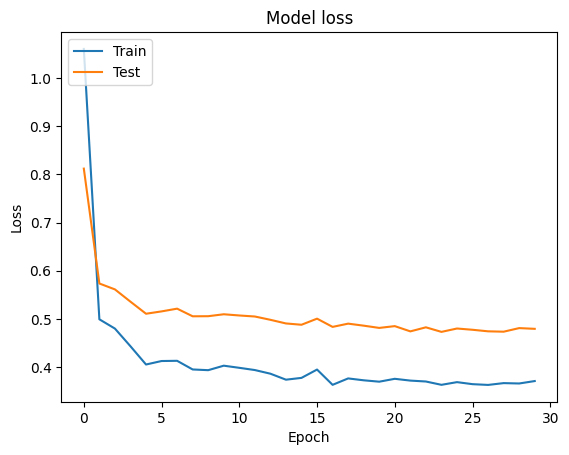

Accuracy: 0.527536231884058
Precision: 0.44085368452457063
Recall: 0.4107289519735563
F1-Score: 0.36742707554225873
Cohen Kappa Score: 0.3706138548771468
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_34 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_35 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_17 (Gl  (None, 128)              0 

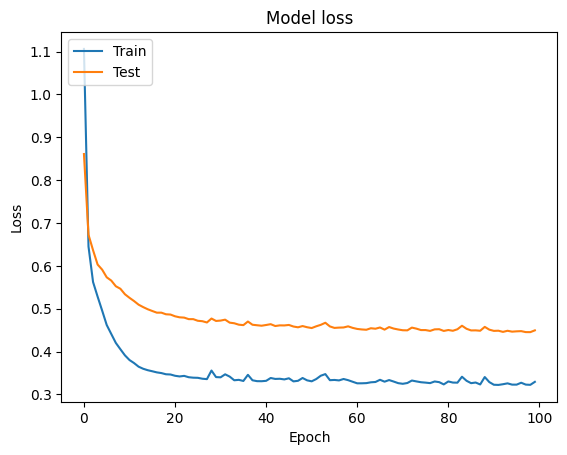

Accuracy: 0.42318840579710143
Precision: 0.32186572700296734
Recall: 0.27364864864864863
F1-Score: 0.18869133019061285
Cohen Kappa Score: 0.06308226268038741

-----------------------Logistic Regression-----------------------
Accuracy: 0.6550724637681159
Precision: 0.5001248095736285
Recall: 0.511494264048221
F1-Score: 0.5047298452482001
Cohen Kappa Score: 0.6304039810623078


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.48695652173913045
Precision: 0.4480701582958765
Recall: 0.3309548901419405
F1-Score: 0.32013360275325015
Cohen Kappa Score: 0.3265970031545742


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.5449275362318841
Precision: 0.4161965811965812
Recall: 0.41367334240715536
F1-Score: 0.4146778630529956
Cohen Kappa Score: 0.4717051757579882


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.6086956521739131
Precision: 0.5046444540564778
Recall: 0.5171422460487208
F1-Score: 0.50980

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 22/22 [00:05<00:00,  4.31it/s]


-----------------------LSTM-----------------------


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_61 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_733 (Dropout)       (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
11/11 [==============================] - 6s 33ms/step - loss: 1.1392 - mae: 0.8451
Epoch 2/30
11/11 [==============================] - 0s 37ms/step - loss: 0.6433 -

Accuracy: 0.5333333333333333
Precision: 0.4423894499973834
Recall: 0.4200433361352386
F1-Score: 0.40076102833771543
Cohen Kappa Score: 0.4804624772508297
-----------------------BiLSTM-----------------------


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_30 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_734 (Dropout)       (None, 200)               0         
                                                                 
 dense_49 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
22/22 [=========================

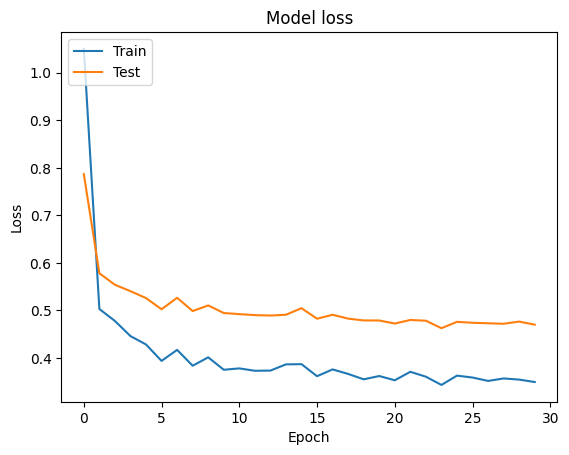

Accuracy: 0.6057971014492753
Precision: 0.4734701572936867
Recall: 0.4701053516391146
F1-Score: 0.4626201345407532
Cohen Kappa Score: 0.5950676102703716
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_36 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_18 (Gl  (None, 128)              0  

Accuracy: 0.4463768115942029
Precision: 0.3086569579288026
Recall: 0.33067152330251237
F1-Score: 0.2676029315835924
Cohen Kappa Score: 0.2433297114572015

-----------------------Logistic Regression-----------------------
Accuracy: 0.5594202898550724
Precision: 0.47039436440543203
Recall: 0.436101055384328
F1-Score: 0.41789965076136704
Cohen Kappa Score: 0.5099814262747975


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4028985507246377
Precision: 0.32634671614934774
Recall: 0.30980237227981694
F1-Score: 0.2767893180671524
Cohen Kappa Score: 0.26442851754055074


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.30144927536231886
Precision: 0.34710996240601505
Recall: 0.28776576071728777
F1-Score: 0.1819282945736434
Cohen Kappa Score: 0.11419342827081858


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.591304347826087
Precision: 0.4490922702601534
Recall: 0.46481591482207907
F1-Score: 0.456

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:04<00:00,  4.95it/s]


-----------------------LSTM-----------------------


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_65 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_772 (Dropout)       (None, 128)               0         
                                                                 
 dense_51 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 21ms/step - loss: 1.0407 - mae: 0.8299
Epoch 2/30
12/12 [==============================] - 0s 32ms/step - loss: 0.6819 -

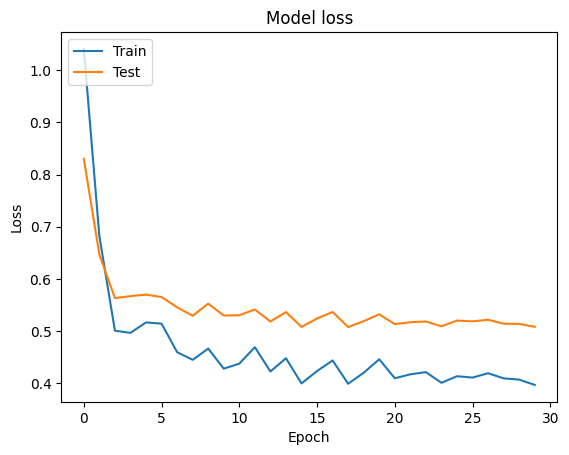

Accuracy: 0.519774011299435
Precision: 0.38794053105113013
Recall: 0.40389384025139363
F1-Score: 0.37471377602641254
Cohen Kappa Score: 0.5087241209643844
-----------------------BiLSTM-----------------------


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_32 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_33 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_773 (Dropout)       (None, 200)               0         
                                                                 
 dense_52 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

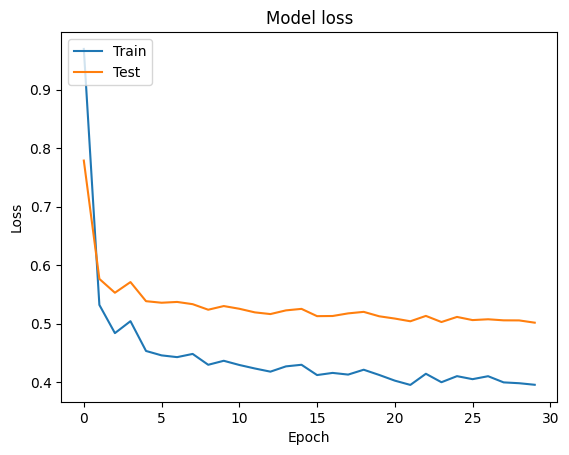

Accuracy: 0.5734463276836158
Precision: 0.679553227255601
Recall: 0.43351419822958676
F1-Score: 0.3837013117372937
Cohen Kappa Score: 0.5043432160189225
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_38 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_39 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_19 (Gl  (None, 128)              0  

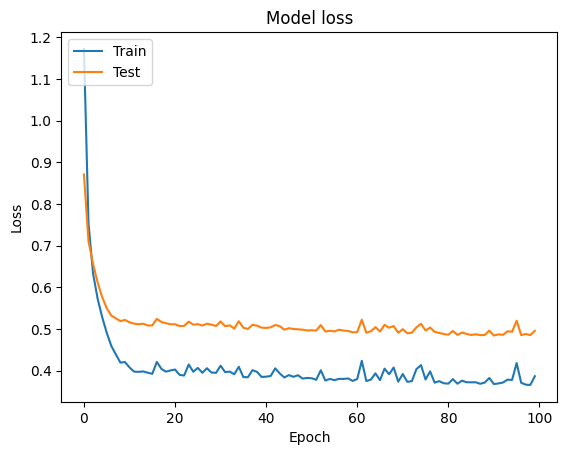

Accuracy: 0.5056497175141242
Precision: 0.5099573883645584
Recall: 0.37702953923061333
F1-Score: 0.30508239707667245
Cohen Kappa Score: 0.47094070815001055

-----------------------Logistic Regression-----------------------
Accuracy: 0.5621468926553672
Precision: 0.6269178447971018
Recall: 0.493198236485507
F1-Score: 0.4955107391830661
Cohen Kappa Score: 0.5855565936537597


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4943502824858757
Precision: 0.4742789102051692
Recall: 0.4492640614643494
F1-Score: 0.45569410067612104
Cohen Kappa Score: 0.5764562737642586


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.3898305084745763
Precision: 0.3139584824624195
Recall: 0.35312326243640846
F1-Score: 0.29041577689416953
Cohen Kappa Score: 0.21578322149805773


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5282485875706214
Precision: 0.5128536501377411
Recall: 0.5089695350842031
F1-Score: 0.510421

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:05<00:00,  4.50it/s]


-----------------------LSTM-----------------------


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_69 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_811 (Dropout)       (None, 128)               0         
                                                                 
 dense_54 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 7s 23ms/step - loss: 1.0760 - mae: 0.8432
Epoch 2/30
12/12 [==============================] - 0s 22ms/step - loss: 0.6404 -

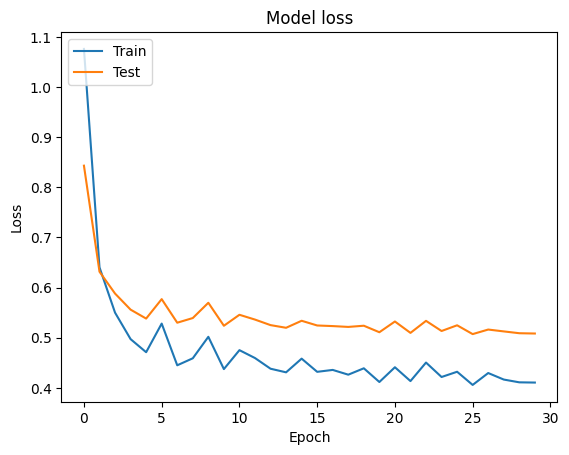

Accuracy: 0.536723163841808
Precision: 0.40038029100529104
Recall: 0.4141792162231539
F1-Score: 0.37562097424085683
Cohen Kappa Score: 0.5621013568363677
-----------------------BiLSTM-----------------------


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_34 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_35 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_812 (Dropout)       (None, 200)               0         
                                                                 
 dense_55 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

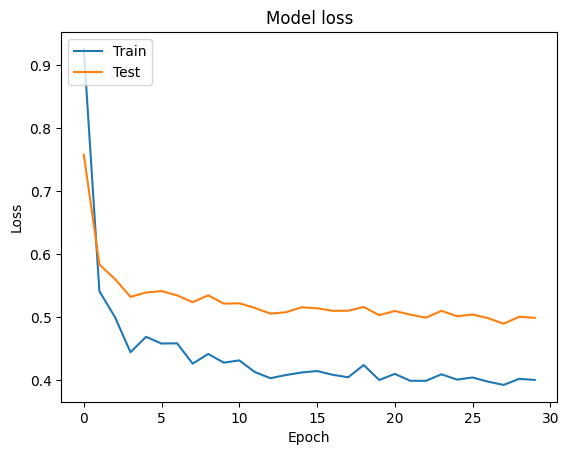

Accuracy: 0.5028248587570622
Precision: 0.45263418498712615
Recall: 0.442055798960296
F1-Score: 0.4084159739114164
Cohen Kappa Score: 0.4495891220809932
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_40 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_41 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_20 (Gl  (None, 128)              0  

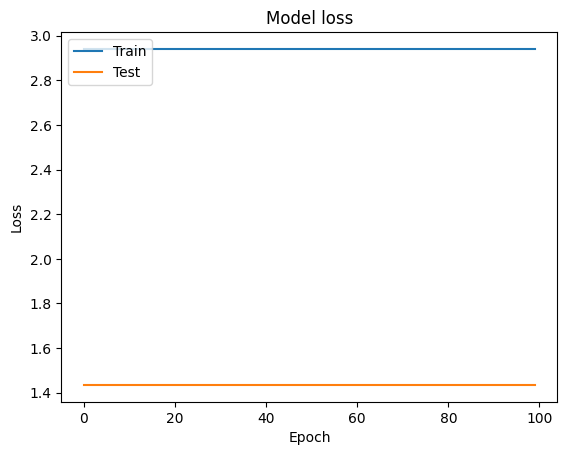

Accuracy: 0.18361581920903955
Precision: 0.04590395480225989
Recall: 0.25
F1-Score: 0.07756563245823389
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.5225988700564972
Precision: 0.4263640238704177
Recall: 0.41213167691993374
F1-Score: 0.36738674759103995
Cohen Kappa Score: 0.526389265909179


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4717514124293785
Precision: 0.34876715226984223
Recall: 0.39499387074073233
F1-Score: 0.34941855530090826
Cohen Kappa Score: 0.48814687783718347


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.22033898305084745
Precision: 0.3676169590643275
Recall: 0.30609501137667355
F1-Score: 0.1701918559108583
Cohen Kappa Score: 0.18511193606432474


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.53954802259887
Precision: 0.5284406565656565
Recall: 0.5315582855885573
F1-Score: 0.527501200031018
Cohen Kappa Scor

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:05<00:00,  3.89it/s]


-----------------------LSTM-----------------------


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_73 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_850 (Dropout)       (None, 128)               0         
                                                                 
 dense_57 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 5s 20ms/step - loss: 1.2962 - mae: 0.9148
Epoch 2/30
12/12 [==============================] - 0s 22ms/step - loss: 0.6278 -

Accuracy: 0.6016949152542372
Precision: 0.44380909438705796
Recall: 0.5540174600219284
F1-Score: 0.48407633384336785
Cohen Kappa Score: 0.6894769463499701
-----------------------BiLSTM-----------------------


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_36 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_37 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_851 (Dropout)       (None, 200)               0         
                                                                 
 dense_58 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

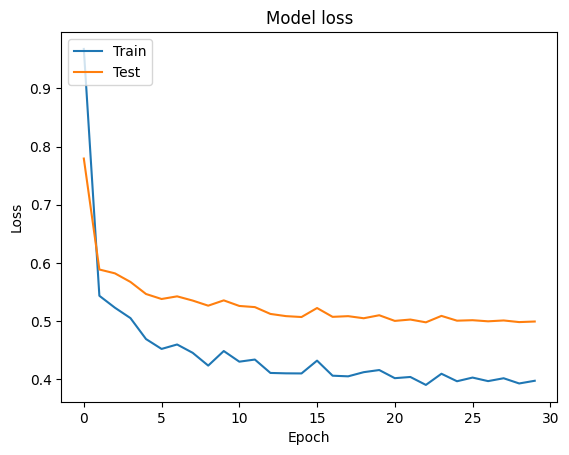

Accuracy: 0.6299435028248588
Precision: 0.6184593023255813
Recall: 0.5989300000564197
F1-Score: 0.5999698582397973
Cohen Kappa Score: 0.7074081632653062
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_42 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_21 (Gl  (None, 128)              0  

Accuracy: 0.1553672316384181
Precision: 0.03884180790960452
Recall: 0.25
F1-Score: 0.06723716381418093
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.3531073446327684
Precision: 0.46984989648033126
Recall: 0.4024346048457015
F1-Score: 0.33781597423551435
Cohen Kappa Score: 0.45793759034373493


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4435028248587571
Precision: 0.4693558963830571
Recall: 0.4728157576509839
F1-Score: 0.44778031641826954
Cohen Kappa Score: 0.6305483138155634


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.480225988700565
Precision: 0.39981938491449776
Recall: 0.3827344380314032
F1-Score: 0.3531260896637609
Cohen Kappa Score: 0.36744098561083416


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.53954802259887
Precision: 0.5344404674145062
Recall: 0.5230586445350921
F1-Score: 0.515751148175006
Cohen Kappa Score: 0

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:04<00:00,  5.04it/s]


-----------------------LSTM-----------------------


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_77 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_889 (Dropout)       (None, 128)               0         
                                                                 
 dense_60 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 34ms/step - loss: 1.0945 - mae: 0.8387
Epoch 2/30
12/12 [==============================] - 0s 28ms/step - loss: 0.6370 -

Accuracy: 0.3531073446327684
Precision: 0.2806499830083684
Recall: 0.38436572003657055
F1-Score: 0.30480980555066184
Cohen Kappa Score: 0.49513990694116905
-----------------------BiLSTM-----------------------


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_38 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_39 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_890 (Dropout)       (None, 200)               0         
                                                                 
 dense_61 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

Accuracy: 0.5988700564971752
Precision: 0.6717009322636294
Recall: 0.5434943815996327
F1-Score: 0.5459136587130429
Cohen Kappa Score: 0.6544202548653244
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_44 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_45 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_22 (Gl  (None, 128)              0  

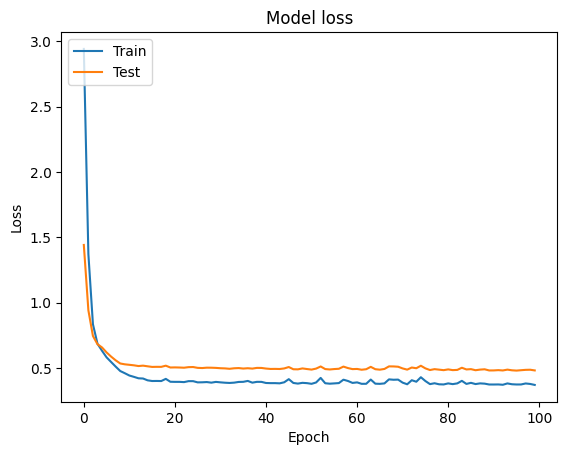

Accuracy: 0.5084745762711864
Precision: 0.5032755298651252
Recall: 0.39896737705266583
F1-Score: 0.31674021697411464
Cohen Kappa Score: 0.5331898757429835

-----------------------Logistic Regression-----------------------
Accuracy: 0.5480225988700564
Precision: 0.577133483126771
Recall: 0.5044165401346611
F1-Score: 0.4968384417809484
Cohen Kappa Score: 0.5531143872711611


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4604519774011299
Precision: 0.43323532186328617
Recall: 0.3854396890282352
F1-Score: 0.3716786799519469
Cohen Kappa Score: 0.5563152673628518


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.192090395480226
Precision: 0.3355785636730262
Recall: 0.2688623459218496
F1-Score: 0.1326641212658665
Cohen Kappa Score: 0.07532626266608844


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5649717514124294
Precision: 0.5908386460867376
Recall: 0.5417170706756824
F1-Score: 0.5530429972

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:05<00:00,  4.29it/s]


-----------------------LSTM-----------------------


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_81 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_928 (Dropout)       (None, 128)               0         
                                                                 
 dense_63 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 7s 23ms/step - loss: 1.1298 - mae: 0.8547
Epoch 2/30
12/12 [==============================] - 0s 25ms/step - loss: 0.6385 -

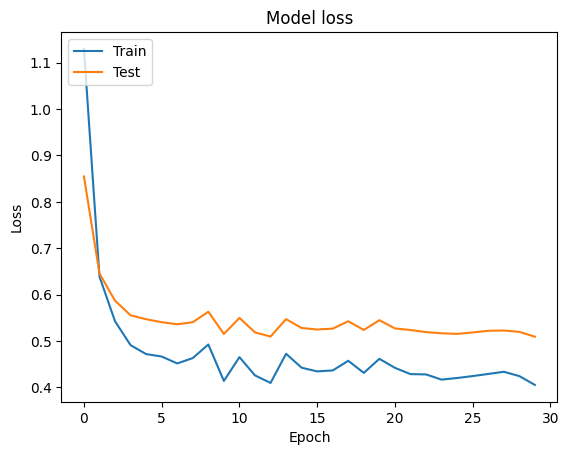

Accuracy: 0.4858757062146893
Precision: 0.24310313739632167
Recall: 0.35553470919324576
F1-Score: 0.28189112088434565
Cohen Kappa Score: 0.4961315689341732
-----------------------BiLSTM-----------------------


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_40 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_41 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_929 (Dropout)       (None, 200)               0         
                                                                 
 dense_64 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

Accuracy: 0.4011299435028249
Precision: 0.3152518036141193
Recall: 0.4377214925995414
F1-Score: 0.3363183657301304
Cohen Kappa Score: 0.5118792059625171
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_46 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_47 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_23 (Gl  (None, 128)              0  

Accuracy: 0.5423728813559322
Precision: 0.5217211787564766
Recall: 0.4034422555764019
F1-Score: 0.3315016700038067
Cohen Kappa Score: 0.5303677293644542

-----------------------Logistic Regression-----------------------
Accuracy: 0.5649717514124294
Precision: 0.611048537395673
Recall: 0.5174949733368301
F1-Score: 0.5180971968338582
Cohen Kappa Score: 0.5798274509803921


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5056497175141242
Precision: 0.5048340654253097
Recall: 0.4822713456663103
F1-Score: 0.45357982398183727
Cohen Kappa Score: 0.633369078060986


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.3700564971751412
Precision: 0.4542681613577136
Recall: 0.40111847458424954
F1-Score: 0.3136592881853755
Cohen Kappa Score: 0.32159980075133343


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5423728813559322
Precision: 0.5267604460598131
Recall: 0.5237097951004324
F1-Score: 0.51377953767

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:05<00:00,  4.31it/s]


-----------------------LSTM-----------------------


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_85 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_967 (Dropout)       (None, 128)               0         
                                                                 
 dense_66 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 23ms/step - loss: 1.7015 - mae: 1.0367
Epoch 2/30
12/12 [==============================] - 0s 24ms/step - loss: 0.7247 -

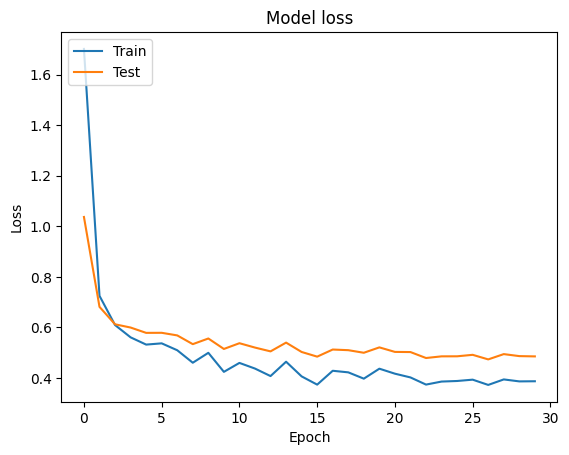

Accuracy: 0.5318559556786704
Precision: 0.5164377061238048
Recall: 0.3585853221990584
F1-Score: 0.35634213037614093
Cohen Kappa Score: 0.5630048653304467
-----------------------BiLSTM-----------------------


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_42 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_43 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_968 (Dropout)       (None, 200)               0         
                                                                 
 dense_67 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

Accuracy: 0.5346260387811634
Precision: 0.4991296296296296
Recall: 0.3488718957007586
F1-Score: 0.3398422916369285
Cohen Kappa Score: 0.5343691287421447
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_48 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_49 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_24 (Gl  (None, 128)              0  

Accuracy: 0.5096952908587258
Precision: 0.3381448412698413
Recall: 0.2521796515147101
F1-Score: 0.2042156997729561
Cohen Kappa Score: 0.5419871540718422

-----------------------Logistic Regression-----------------------
Accuracy: 0.592797783933518
Precision: 0.48218999814091834
Recall: 0.4004474681688636
F1-Score: 0.38451197288279443
Cohen Kappa Score: 0.6632074819746148


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.49584487534626037
Precision: 0.47312107380123825
Recall: 0.3218254002732289
F1-Score: 0.3072436093327335
Cohen Kappa Score: 0.5235976159932236


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.5263157894736842
Precision: 0.34891954022988503
Recall: 0.3439878646693935
F1-Score: 0.3390135917956515
Cohen Kappa Score: 0.6536616565398146


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5789473684210527
Precision: 0.488081058465589
Recall: 0.43873068653241
F1-Score: 0.44057833879

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:10<00:00,  2.25it/s]


-----------------------LSTM-----------------------


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_89 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_1006 (Dropout)      (None, 128)               0         
                                                                 
 dense_69 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 24ms/step - loss: 1.6939 - mae: 1.0306
Epoch 2/30
12/12 [==============================] - 0s 37ms/step - loss: 0.7466 -

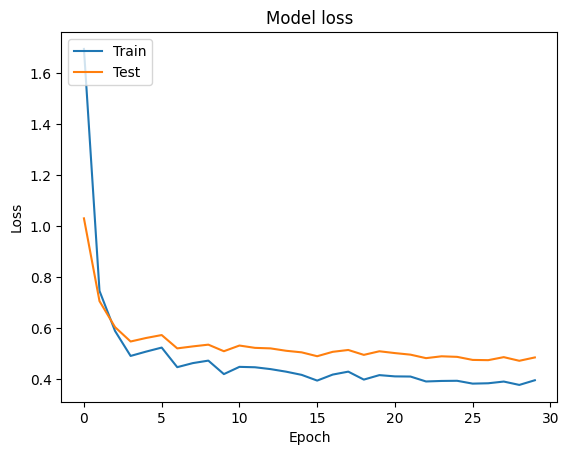

Accuracy: 0.5041551246537396
Precision: 0.46659200944915236
Recall: 0.36090383583552643
F1-Score: 0.35432368353887334
Cohen Kappa Score: 0.5933498948977642
-----------------------BiLSTM-----------------------


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_44 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_45 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1007 (Dropout)      (None, 200)               0         
                                                                 
 dense_70 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

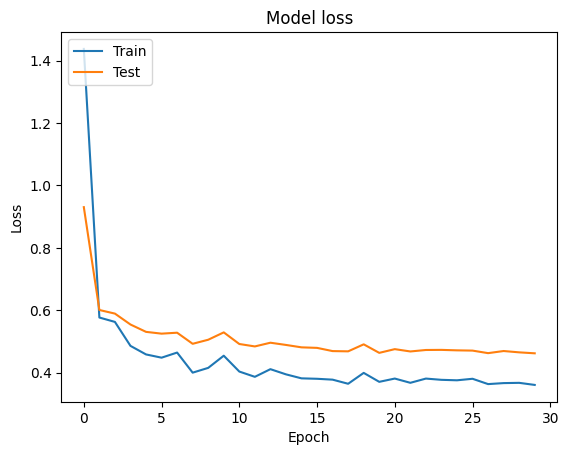

Accuracy: 0.5263157894736842
Precision: 0.33287454787740345
Recall: 0.3523091221476381
F1-Score: 0.32718868847901106
Cohen Kappa Score: 0.5908531583264971
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_50 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_51 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_25 (Gl  (None, 128)              0

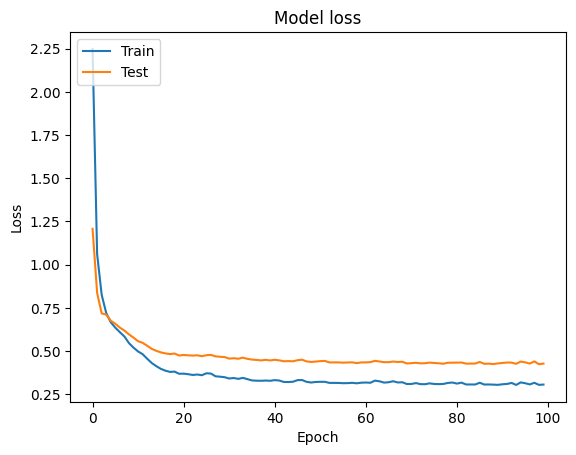

Accuracy: 0.40443213296398894
Precision: 0.47485958485958485
Recall: 0.30150726421631896
F1-Score: 0.2398876522662737
Cohen Kappa Score: 0.3080314356910101

-----------------------Logistic Regression-----------------------
Accuracy: 0.5650969529085873
Precision: 0.6704534922211188
Recall: 0.5143066401363618
F1-Score: 0.5075507419409858
Cohen Kappa Score: 0.7668711656441718


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4986149584487535
Precision: 0.5218132023607405
Recall: 0.3600531983794959
F1-Score: 0.3290959450997338
Cohen Kappa Score: 0.5952813067150635


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.5346260387811634
Precision: 0.21354128214593332
Recall: 0.3241398879194155
F1-Score: 0.25744062262378675
Cohen Kappa Score: 0.5630662020905923


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5595567867036011
Precision: 0.6525865946918579
Recall: 0.4897019764903474
F1-Score: 0.5264782

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:05<00:00,  4.50it/s]


-----------------------LSTM-----------------------


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_93 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_1045 (Dropout)      (None, 128)               0         
                                                                 
 dense_72 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 8s 37ms/step - loss: 1.6592 - mae: 1.0124
Epoch 2/30
12/12 [==============================] - 1s 48ms/step - loss: 0.7848 -

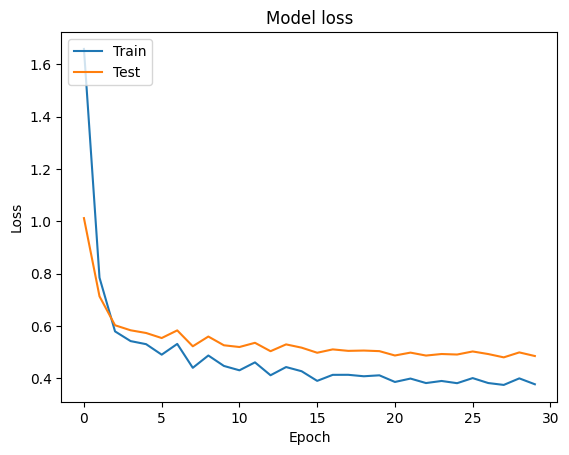

Accuracy: 0.5290858725761773
Precision: 0.41534508076358295
Recall: 0.31170582943028763
F1-Score: 0.2587172533077616
Cohen Kappa Score: 0.49999033673265614
-----------------------BiLSTM-----------------------


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_46 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_47 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1046 (Dropout)      (None, 200)               0         
                                                                 
 dense_73 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

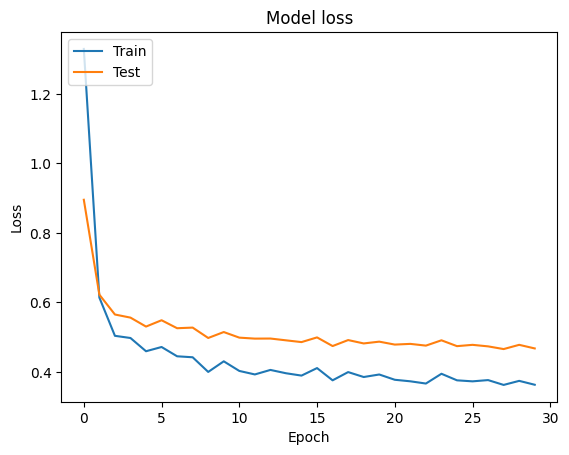

Accuracy: 0.5235457063711911
Precision: 0.4844898838466881
Recall: 0.41223778838531827
F1-Score: 0.3945762603752222
Cohen Kappa Score: 0.5834230040753526
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_52 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_53 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_26 (Gl  (None, 128)              0 

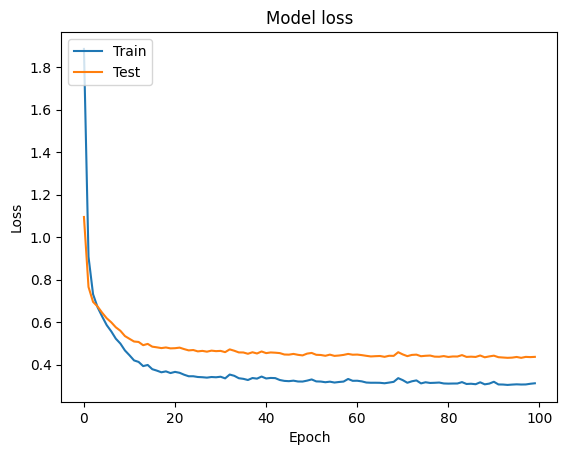

Accuracy: 0.556786703601108
Precision: 0.42407553107789137
Recall: 0.3242573283494
F1-Score: 0.2691326100807585
Cohen Kappa Score: 0.5308289630940641

-----------------------Logistic Regression-----------------------
Accuracy: 0.6371191135734072
Precision: 0.7802369652406418
Recall: 0.4931949463467838
F1-Score: 0.5371914902493108
Cohen Kappa Score: 0.7018420730115256


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5595567867036011
Precision: 0.4274988166122723
Recall: 0.3421674760381181
F1-Score: 0.32150038772571177
Cohen Kappa Score: 0.5582740294764013


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.3961218836565097
Precision: 0.21460853520393847
Recall: 0.28173596082803243
F1-Score: 0.2143101343101343
Cohen Kappa Score: 0.5298694360036064


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5817174515235457
Precision: 0.578842453278429
Recall: 0.4874421676198497
F1-Score: 0.4948882541834

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:06<00:00,  3.64it/s]


-----------------------LSTM-----------------------


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 1, 400)            1870400   
                                                                 
 lstm_97 (LSTM)              (None, 128)               270848    
                                                                 
 dropout_1084 (Dropout)      (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 35ms/step - loss: 1.6582 - mae: 1.0087
Epoch 2/30
12/12 [==============================] - 0s 31ms/step - loss: 0.8293 -

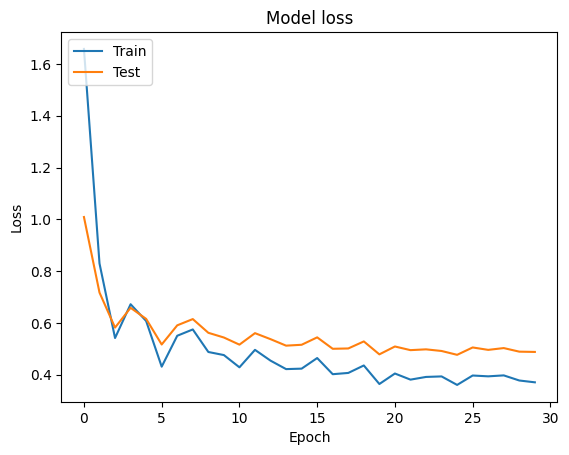

Accuracy: 0.4099722991689751
Precision: 0.246477620954213
Recall: 0.3179552252333907
F1-Score: 0.26900343642611685
Cohen Kappa Score: 0.6021593047217991
-----------------------BiLSTM-----------------------


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_48 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_49 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1085 (Dropout)      (None, 200)               0         
                                                                 
 dense_76 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

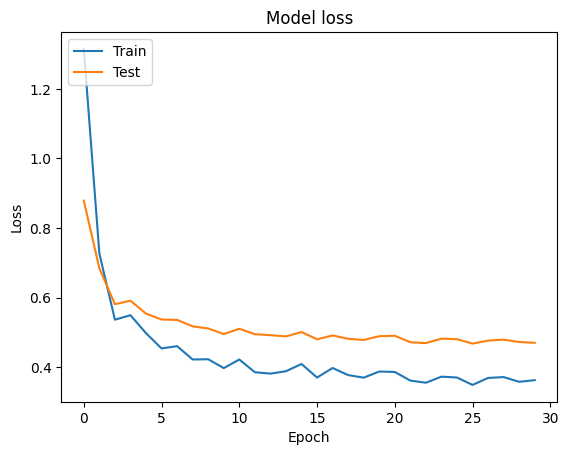

Accuracy: 0.5983379501385041
Precision: 0.5287510692899915
Recall: 0.48253011528186
F1-Score: 0.47842816017017176
Cohen Kappa Score: 0.6752225090907569
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_54 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_55 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_27 (Gl  (None, 128)              0   

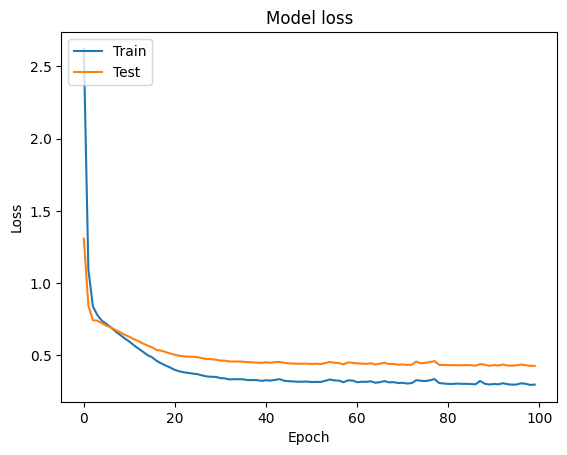

Accuracy: 0.5346260387811634
Precision: 0.38463194618210883
Recall: 0.36253601831867033
F1-Score: 0.3388588403271865
Cohen Kappa Score: 0.5671148987434258

-----------------------Logistic Regression-----------------------
Accuracy: 0.6371191135734072
Precision: 0.6267197140056506
Recall: 0.5263354126763897
F1-Score: 0.5323664920705096
Cohen Kappa Score: 0.7319751912716737


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5318559556786704
Precision: 0.37434134842055633
Recall: 0.3627901012247971
F1-Score: 0.33685344827586217
Cohen Kappa Score: 0.611758379637928


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.5207756232686981
Precision: 0.2759733558495169
Recall: 0.31945646576753256
F1-Score: 0.2588682674495823
Cohen Kappa Score: 0.5434610287844224


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.554016620498615
Precision: 0.45723562970114173
Recall: 0.4380544679647372
F1-Score: 0.44161064

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


-----------------------LSTM-----------------------


Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_101 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1123 (Dropout)      (None, 128)               0         
                                                                 
 dense_78 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 27ms/step - loss: 1.6355 - mae: 1.0025
Epoch 2/30
12/12 [==============================] - 0s 26ms/step - loss: 0.7635 -

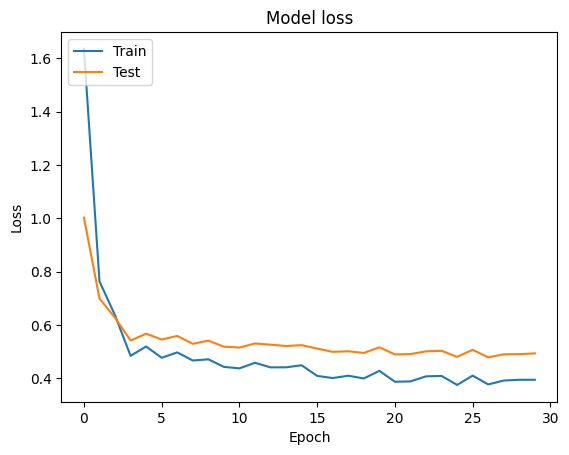

Accuracy: 0.5734072022160664
Precision: 0.3707609348135601
Recall: 0.3866742614111035
F1-Score: 0.3643015969274308
Cohen Kappa Score: 0.6184075677821955
-----------------------BiLSTM-----------------------


Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_50 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_51 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1124 (Dropout)      (None, 200)               0         
                                                                 
 dense_79 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

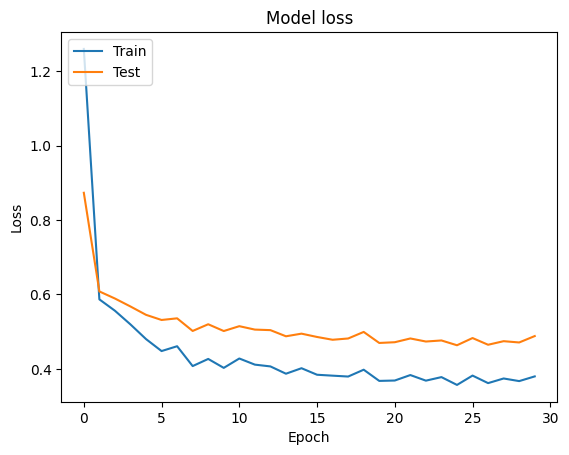

Accuracy: 0.5346260387811634
Precision: 0.4615925596561435
Recall: 0.4326063643958381
F1-Score: 0.41995142844229694
Cohen Kappa Score: 0.6612489155645261
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_56 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_57 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_28 (Gl  (None, 128)              0 

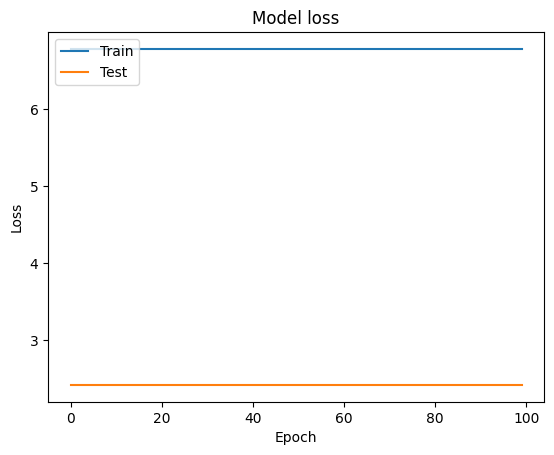

Accuracy: 0.013850415512465374
Precision: 0.002770083102493075
Recall: 0.2
F1-Score: 0.005464480874316939
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.5734072022160664
Precision: 0.5647330008121375
Recall: 0.44501921470342526
F1-Score: 0.44314426029575105
Cohen Kappa Score: 0.7055404881828748


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4293628808864266
Precision: 0.37042583768247483
Recall: 0.2816064403432824
F1-Score: 0.2491821361312887
Cohen Kappa Score: 0.47697274604424056


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.5124653739612188
Precision: 0.21186395642354192
Recall: 0.3039781271360219
F1-Score: 0.24968863877485123
Cohen Kappa Score: 0.5460267032497578


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.6260387811634349
Precision: 0.7369248127758766
Recall: 0.5275115060378218
F1-Score: 0.5661573461532954
Cohen Kappa S

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:10<00:00,  2.25it/s]


-----------------------LSTM-----------------------


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_105 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1162 (Dropout)      (None, 128)               0         
                                                                 
 dense_81 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 7s 28ms/step - loss: 1.8409 - mae: 1.0323
Epoch 2/30
12/12 [==============================] - 0s 31ms/step - loss: 0.9739 -

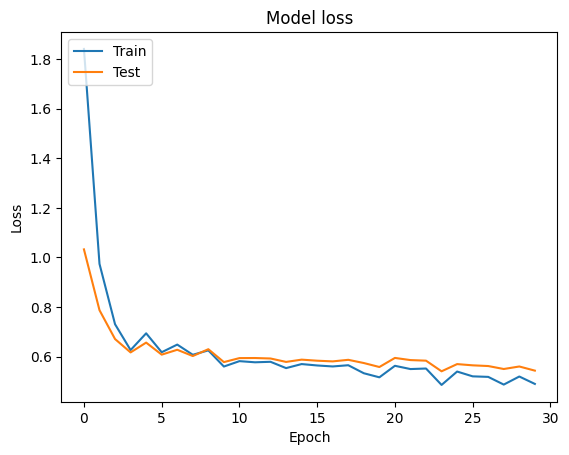

Accuracy: 0.55
Precision: 0.5359135520967582
Recall: 0.34930123407249003
F1-Score: 0.3425159743877986
Cohen Kappa Score: 0.532949601160261
-----------------------BiLSTM-----------------------


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_52 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_53 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1163 (Dropout)      (None, 200)               0         
                                                                 
 dense_82 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

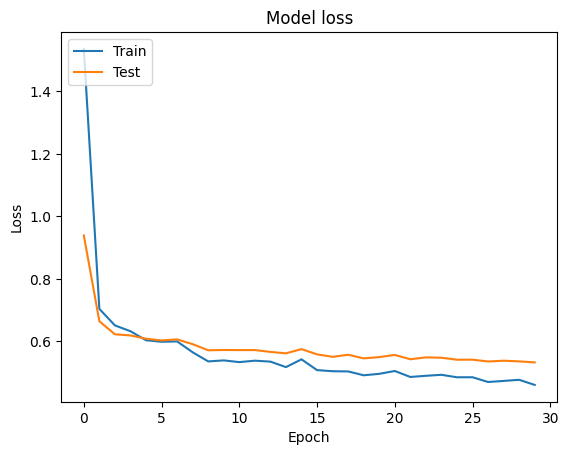

Accuracy: 0.5694444444444444
Precision: 0.49125860373647984
Recall: 0.43210554817612323
F1-Score: 0.44589023601936084
Cohen Kappa Score: 0.651828170754641
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_58 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_59 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_29 (Gl  (None, 128)              0

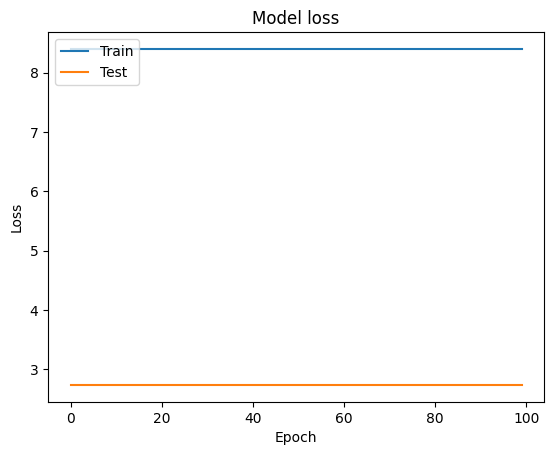

Accuracy: 0.025
Precision: 0.005
Recall: 0.2
F1-Score: 0.009756097560975611
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.5527777777777778
Precision: 0.5102246985750822
Recall: 0.4398324826526901
F1-Score: 0.4202020599719658
Cohen Kappa Score: 0.6138443935926774


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5527777777777778
Precision: 0.45401046268309697
Recall: 0.36696984704680197
F1-Score: 0.3699122493391978
Cohen Kappa Score: 0.6132854461214613


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.225
Precision: 0.13430365767221059
Recall: 0.23696594427244583
F1-Score: 0.12510298735344108
Cohen Kappa Score: 0.28977469670710565


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5277777777777778
Precision: 0.4187922077922078
Recall: 0.4088768673279654
F1-Score: 0.40721705936019986
Cohen Kappa Score: 0.6111828384149369


---------------

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:10<00:00,  2.25it/s]


-----------------------LSTM-----------------------


Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_108 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_109 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1201 (Dropout)      (None, 128)               0         
                                                                 
 dense_84 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 25ms/step - loss: 1.9273 - mae: 1.0608
Epoch 2/30
12/12 [==============================] - 0s 26ms/step - loss: 0.9109 -

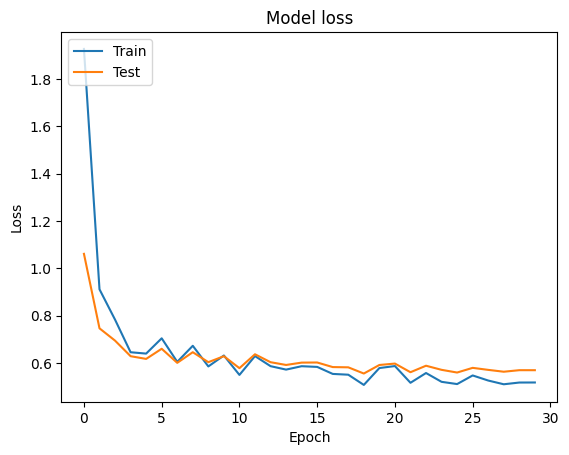

Accuracy: 0.575
Precision: 0.6168696717992492
Recall: 0.4685952380952381
F1-Score: 0.49686955893508655
Cohen Kappa Score: 0.6053161498187676
-----------------------BiLSTM-----------------------


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_54 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_55 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1202 (Dropout)      (None, 200)               0         
                                                                 
 dense_85 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

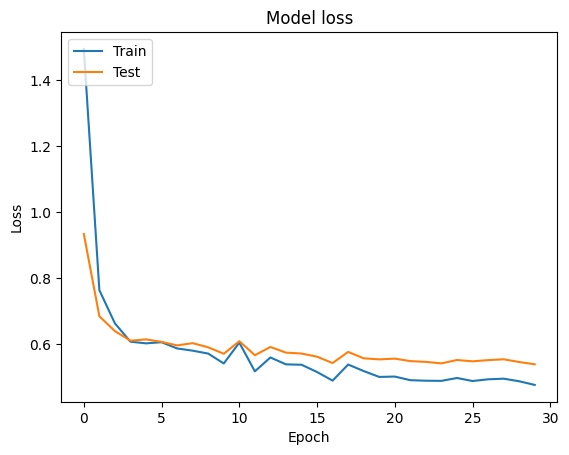

Accuracy: 0.5888888888888889
Precision: 0.40143197148807247
Recall: 0.3661131907308378
F1-Score: 0.3576753122922495
Cohen Kappa Score: 0.5660710779501276
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_60 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_61 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_30 (Gl  (None, 128)              0 

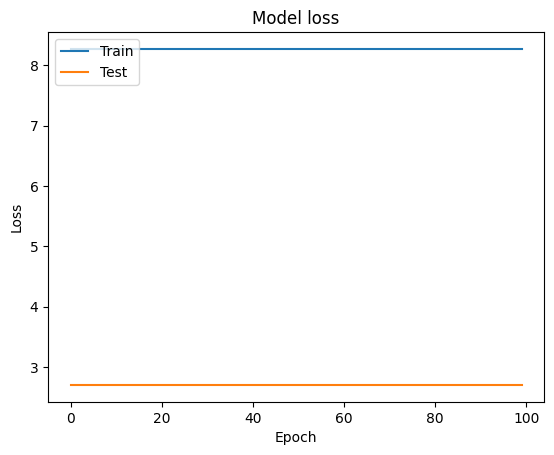

Accuracy: 0.013888888888888888
Precision: 0.0027777777777777775
Recall: 0.2
F1-Score: 0.005479452054794521
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.5111111111111111
Precision: 0.5155434946479722
Recall: 0.47872167048637626
F1-Score: 0.45474025044656213
Cohen Kappa Score: 0.6386554621848739


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.45
Precision: 0.5627316847030872
Recall: 0.41064196587726
F1-Score: 0.41068508584259805
Cohen Kappa Score: 0.5196003074558033


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.5194444444444445
Precision: 0.26971381734573646
Recall: 0.28345887445887447
F1-Score: 0.2682346436202021
Cohen Kappa Score: 0.4506154308015611


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5916666666666667
Precision: 0.5078208094832135
Recall: 0.47038566335625165
F1-Score: 0.47753402678124407
Cohen Kappa Score: 0.609360

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:10<00:00,  2.25it/s]


-----------------------LSTM-----------------------


Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_113 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1240 (Dropout)      (None, 128)               0         
                                                                 
 dense_87 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 7s 27ms/step - loss: 1.8758 - mae: 1.0386
Epoch 2/30
12/12 [==============================] - 0s 27ms/step - loss: 0.9339 -

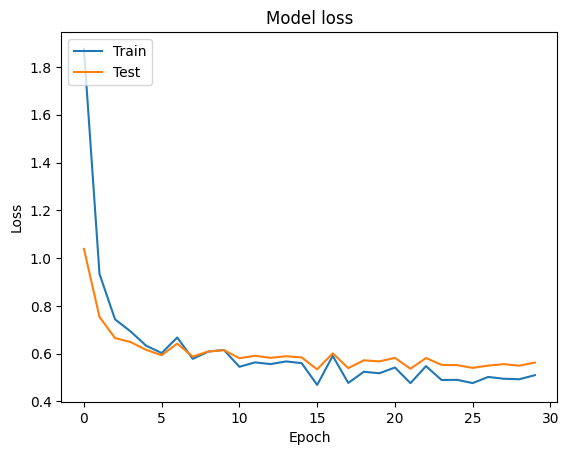

Accuracy: 0.5583333333333333
Precision: 0.5873266805078823
Recall: 0.43203596254764226
F1-Score: 0.4338398580894844
Cohen Kappa Score: 0.6344903471041312
-----------------------BiLSTM-----------------------


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_56 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_57 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1241 (Dropout)      (None, 200)               0         
                                                                 
 dense_88 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

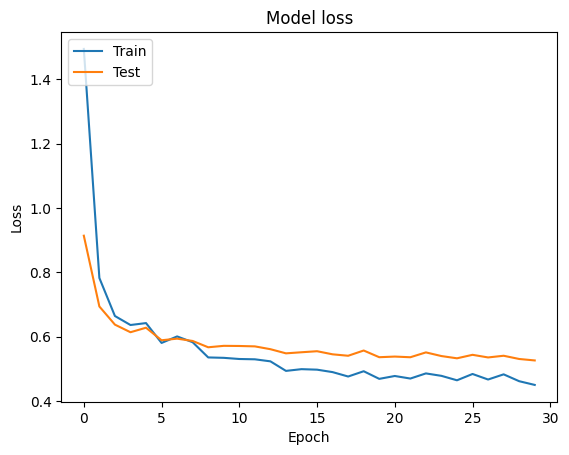

Accuracy: 0.5416666666666666
Precision: 0.4035310635310635
Recall: 0.3343336439888164
F1-Score: 0.3244515754560531
Cohen Kappa Score: 0.5700080009143902
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_62 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_63 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_31 (Gl  (None, 128)              0  

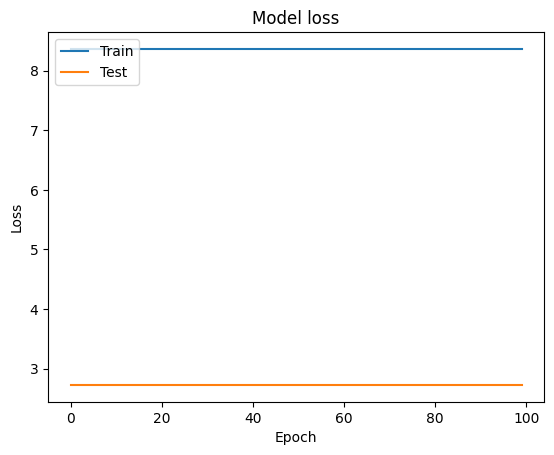

Accuracy: 0.03333333333333333
Precision: 0.006666666666666666
Recall: 0.2
F1-Score: 0.012903225806451613
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.5666666666666667
Precision: 0.6437381765795622
Recall: 0.44204808813262647
F1-Score: 0.43653364179679965
Cohen Kappa Score: 0.6869565217391305


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4583333333333333
Precision: 0.3707297210985736
Recall: 0.36422511499263444
F1-Score: 0.3170040926324247
Cohen Kappa Score: 0.5703182827535158


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.3638888888888889
Precision: 0.4304222118654307
Recall: 0.3059106047092699
F1-Score: 0.22656804910690923
Cohen Kappa Score: 0.24280100496038137


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5555555555555556
Precision: 0.6184776334776334
Recall: 0.44805776855832474
F1-Score: 0.45442116518703984
Cohen Kappa S

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:05<00:00,  4.01it/s]


-----------------------LSTM-----------------------


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_116 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_117 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1279 (Dropout)      (None, 128)               0         
                                                                 
 dense_90 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 8s 32ms/step - loss: 1.8148 - mae: 1.0255
Epoch 2/30
12/12 [==============================] - 0s 26ms/step - loss: 1.0069 -

Accuracy: 0.5805555555555556
Precision: 0.5006853146853147
Recall: 0.37140945386722624
F1-Score: 0.37567568456822775
Cohen Kappa Score: 0.5387191718258397
-----------------------BiLSTM-----------------------


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_58 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_59 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1280 (Dropout)      (None, 200)               0         
                                                                 
 dense_91 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

Accuracy: 0.3861111111111111
Precision: 0.2729923856486199
Recall: 0.2872313341493268
F1-Score: 0.21970406301731535
Cohen Kappa Score: 0.45925875919800185
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_64 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_65 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_32 (Gl  (None, 128)              0

Accuracy: 0.019444444444444445
Precision: 0.0038888888888888888
Recall: 0.2
F1-Score: 0.007629427792915531
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.5138888888888888
Precision: 0.4666346153846154
Recall: 0.3912292358803987
F1-Score: 0.3440544341378184
Cohen Kappa Score: 0.4528083381586566


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.4166666666666667
Precision: 0.27456200287326116
Recall: 0.2798188494492044
F1-Score: 0.2460073388463631
Cohen Kappa Score: 0.4515211624405516


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.5055555555555555
Precision: 0.20510715914272684
Recall: 0.2928372093023256
F1-Score: 0.2411036657469452
Cohen Kappa Score: 0.29943346690617667


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5861111111111111
Precision: 0.5203804170739654
Recall: 0.5416453925511453
F1-Score: 0.5162956750552659
Cohen Kappa Sco

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 23/23 [00:10<00:00,  2.25it/s]


-----------------------LSTM-----------------------


Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_121 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1318 (Dropout)      (None, 128)               0         
                                                                 
 dense_93 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 8s 27ms/step - loss: 1.8414 - mae: 1.0396
Epoch 2/30
12/12 [==============================] - 0s 32ms/step - loss: 0.9196 -

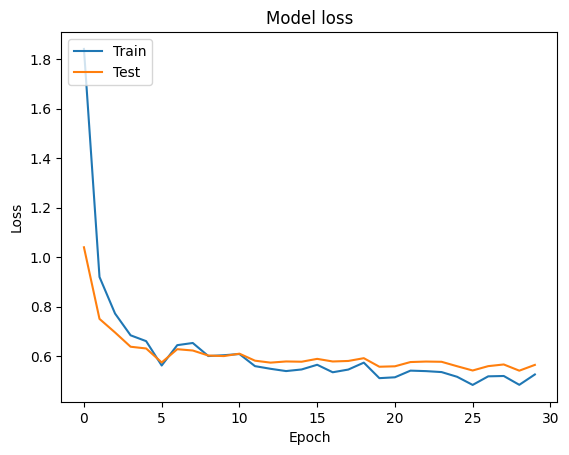

Accuracy: 0.5222222222222223
Precision: 0.44323283949842673
Recall: 0.30150634505473217
F1-Score: 0.28413150946670646
Cohen Kappa Score: 0.48218584496870476
-----------------------BiLSTM-----------------------


Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_60 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_61 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1319 (Dropout)      (None, 200)               0         
                                                                 
 dense_94 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [=========================

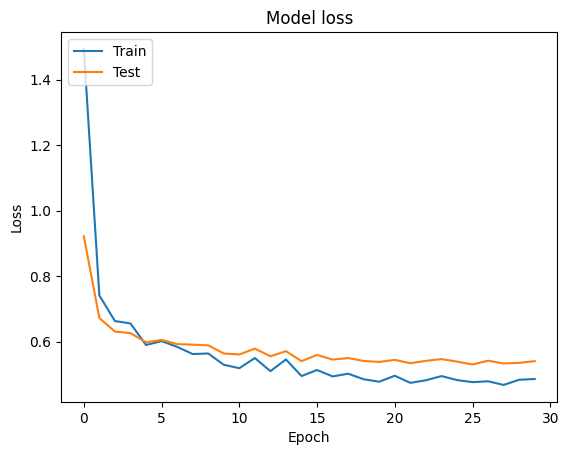

Accuracy: 0.4444444444444444
Precision: 0.21059508124725515
Recall: 0.29337567982729273
F1-Score: 0.2327921471866116
Cohen Kappa Score: 0.4228519433251007
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_66 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_67 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_33 (Gl  (None, 128)              0

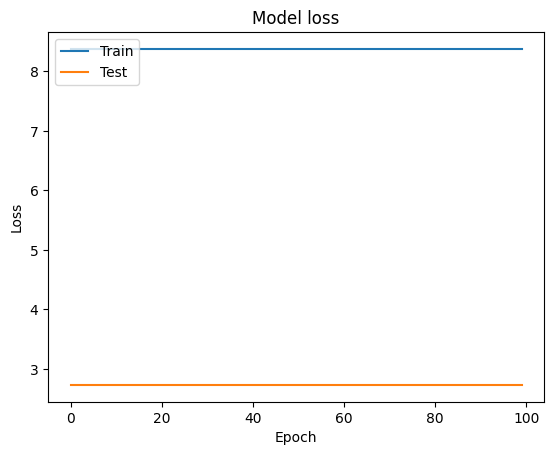

Accuracy: 0.030555555555555555
Precision: 0.0061111111111111106
Recall: 0.2
F1-Score: 0.011859838274932616
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.4861111111111111
Precision: 0.6161478477854023
Recall: 0.42722503399922757
F1-Score: 0.3905030824646574
Cohen Kappa Score: 0.5454060924111352


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.5027777777777778
Precision: 0.4263254163254164
Recall: 0.3149636733507701
F1-Score: 0.3006299933129202
Cohen Kappa Score: 0.4883445491251682


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.4444444444444444
Precision: 0.17252090800477898
Recall: 0.24244239631336403
F1-Score: 0.19705069124423963
Cohen Kappa Score: 0.21441022661243458


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.5305555555555556
Precision: 0.38170744902064874
Recall: 0.38522467167628455
F1-Score: 0.37934417953950766
Cohen Kapp

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


-----------------------LSTM-----------------------


Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_124 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_125 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1357 (Dropout)      (None, 128)               0         
                                                                 
 dense_96 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 6s 28ms/step - loss: 117.1044 - mae: 9.3163
Epoch 2/30
10/10 [==============================] - 0s 29ms/step - loss: 38.403

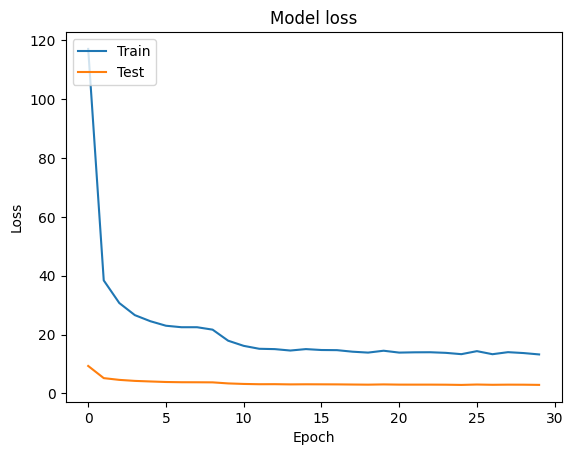

Accuracy: 0.10828025477707007
Precision: 0.03932999061224422
Recall: 0.05913692477713598
F1-Score: 0.04273299212002353
Cohen Kappa Score: 0.5212049509218608
-----------------------BiLSTM-----------------------


Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_62 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_63 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1358 (Dropout)      (None, 200)               0         
                                                                 
 dense_97 (Dense)            (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [=========================

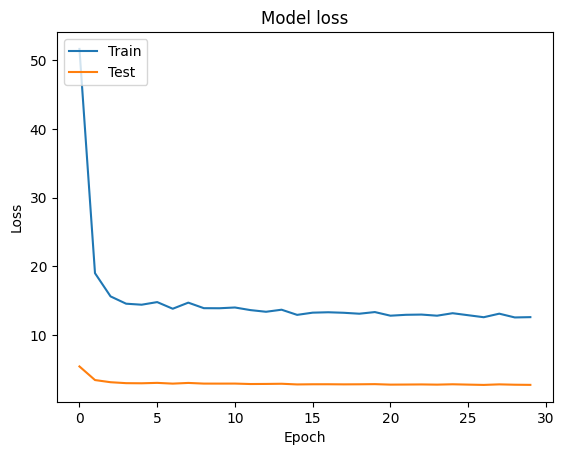

Accuracy: 0.10828025477707007
Precision: 0.06059680301596384
Recall: 0.06486220354094292
F1-Score: 0.052778434052018736
Cohen Kappa Score: 0.5219201952751262
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_68 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_69 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_34 (Gl  (None, 128)            

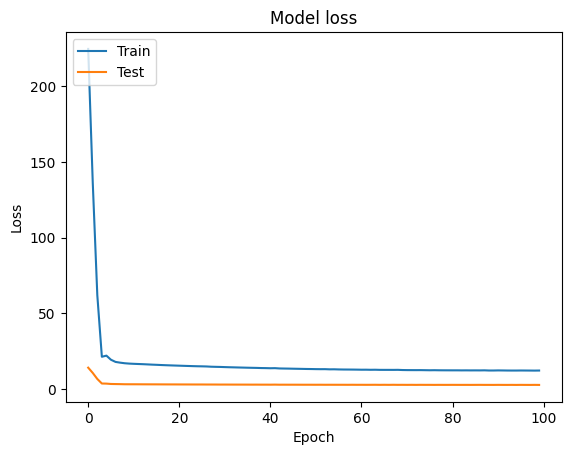

Accuracy: 0.11146496815286625
Precision: 0.032147470371398965
Recall: 0.06459112439229592
F1-Score: 0.04164911632938212
Cohen Kappa Score: 0.4316505565481805

-----------------------Logistic Regression-----------------------
Accuracy: 0.16560509554140126
Precision: 0.06261518939880749
Recall: 0.12453102453102453
F1-Score: 0.07668062818035365
Cohen Kappa Score: 0.6491953695119923


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.15286624203821655
Precision: 0.04407485789064736
Recall: 0.11779269117978795
F1-Score: 0.05086178369281136
Cohen Kappa Score: 0.554827793266323


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.12420382165605096
Precision: 0.0187214936118379
Recall: 0.07859477124183006
F1-Score: 0.027650758687150712
Cohen Kappa Score: 0.5022727018803559


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.11464968152866242
Precision: 0.09988350834191459
Recall: 0.156436356683861
F1-Scor

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


-----------------------LSTM-----------------------


Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_129 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1396 (Dropout)      (None, 128)               0         
                                                                 
 dense_99 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 6s 31ms/step - loss: 111.5337 - mae: 8.8977
Epoch 2/30
10/10 [==============================] - 0s 32ms/step - loss: 34.125

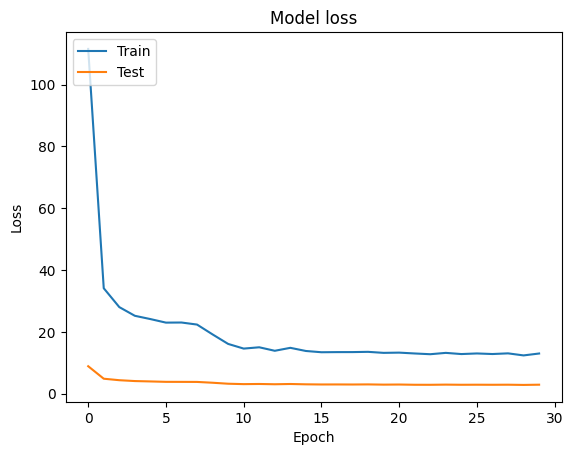

Accuracy: 0.15605095541401273
Precision: 0.0651770792399037
Recall: 0.09810106833431045
F1-Score: 0.07526384102968095
Cohen Kappa Score: 0.6099481842076215
-----------------------BiLSTM-----------------------


Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_64 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_65 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1397 (Dropout)      (None, 200)               0         
                                                                 
 dense_100 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [=========================

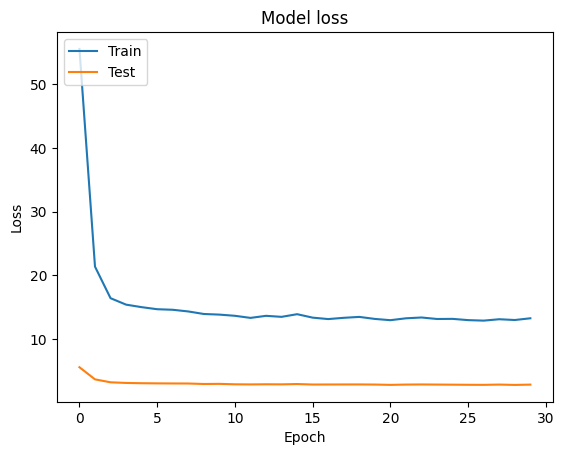

Accuracy: 0.12101910828025478
Precision: 0.07389640164828616
Recall: 0.08215728292726533
F1-Score: 0.0680213586385256
Cohen Kappa Score: 0.5618074057188448
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_70 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_71 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_35 (Gl  (None, 128)              

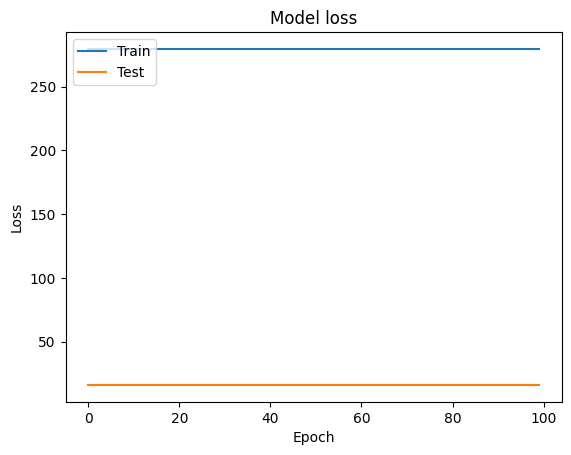

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.13694267515923567
Precision: 0.07530154921650523
Recall: 0.11655328798185942
F1-Score: 0.07290686814034956
Cohen Kappa Score: 0.6250183965592


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.13694267515923567
Precision: 0.07267546780704674
Recall: 0.10502213506967269
F1-Score: 0.0783890556424386
Cohen Kappa Score: 0.5162557854761811


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.11464968152866242
Precision: 0.01722132832752302
Recall: 0.06831741417497231
F1-Score: 0.026892332066608314
Cohen Kappa Score: 0.2706147177582441


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.1624203821656051
Precision: 0.12652632627256685
Recall: 0.17257696276591625
F1-Score: 0.13866900463931153
Cohen Kappa Score: 0.5633418770791296


------------------

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


-----------------------LSTM-----------------------


Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_133 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1435 (Dropout)      (None, 128)               0         
                                                                 
 dense_102 (Dense)           (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 6s 32ms/step - loss: 105.6268 - mae: 8.6273
Epoch 2/30
10/10 [==============================] - 0s 34ms/step - loss: 30.489

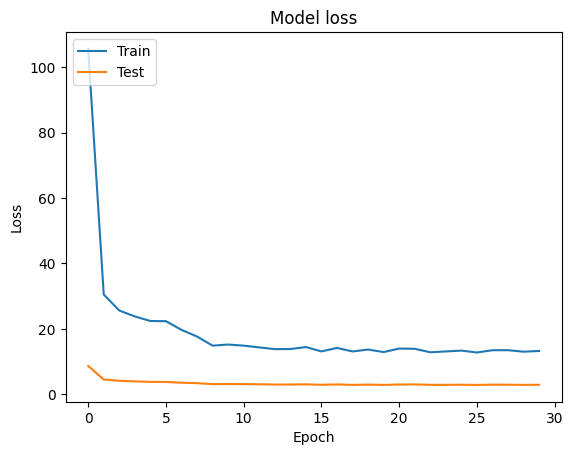

Accuracy: 0.09872611464968153
Precision: 0.04018065794169359
Recall: 0.06881640153698977
F1-Score: 0.04820931842135672
Cohen Kappa Score: 0.4567682260781061
-----------------------BiLSTM-----------------------


Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_66 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_67 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1436 (Dropout)      (None, 200)               0         
                                                                 
 dense_103 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [=========================

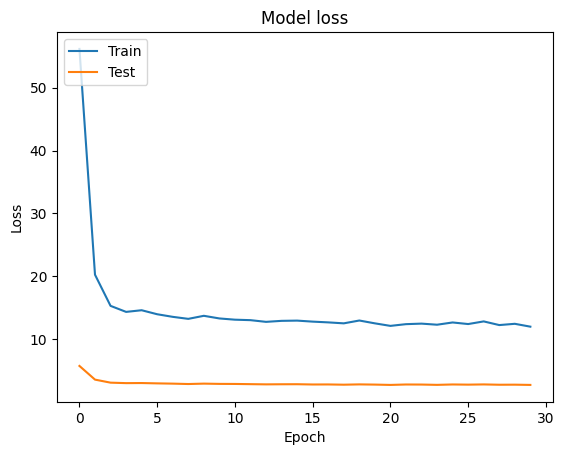

Accuracy: 0.1178343949044586
Precision: 0.053399185966592655
Recall: 0.07961876160405573
F1-Score: 0.05658652584694342
Cohen Kappa Score: 0.4547373979018883
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_72 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_73 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_36 (Gl  (None, 128)             

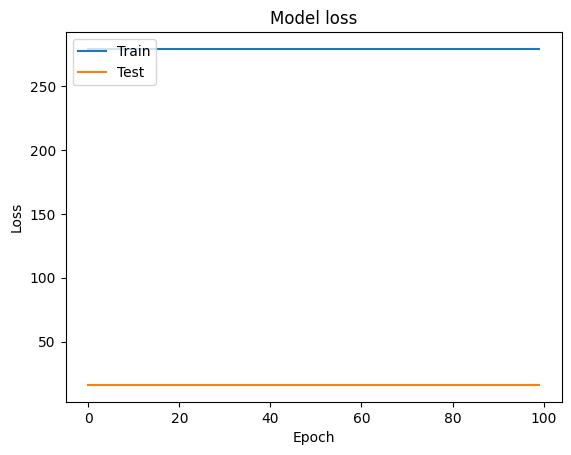

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.11464968152866242
Precision: 0.04021481399577375
Recall: 0.09418367138955375
F1-Score: 0.04440532556874909
Cohen Kappa Score: 0.5826020253202493


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.10828025477707007
Precision: 0.09482020117014132
Recall: 0.0837547025047025
F1-Score: 0.05367703832820762
Cohen Kappa Score: 0.4228692809683783


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.14968152866242038
Precision: 0.04254971590909091
Recall: 0.08594594594594596
F1-Score: 0.0330509585592987
Cohen Kappa Score: 0.3445051331179044


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.14012738853503184
Precision: 0.116986716986717
Recall: 0.10942189072441173
F1-Score: 0.09675470028433561
Cohen Kappa Score: 0.5237372865676317


------------------

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


-----------------------LSTM-----------------------


Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_136 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_137 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1474 (Dropout)      (None, 128)               0         
                                                                 
 dense_105 (Dense)           (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 6s 28ms/step - loss: 113.1302 - mae: 9.0922
Epoch 2/30
10/10 [==============================] - 0s 28ms/step - loss: 33.691

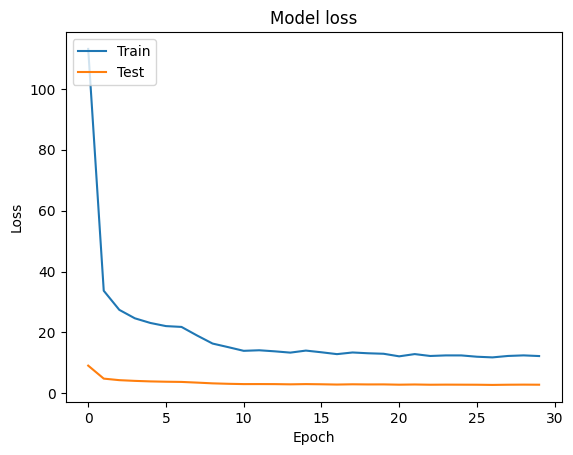

Accuracy: 0.08598726114649681
Precision: 0.051287957114570015
Recall: 0.07033168190128938
F1-Score: 0.05509152161337492
Cohen Kappa Score: 0.5915761721981305
-----------------------BiLSTM-----------------------


Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_68 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_69 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1475 (Dropout)      (None, 200)               0         
                                                                 
 dense_106 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [=========================

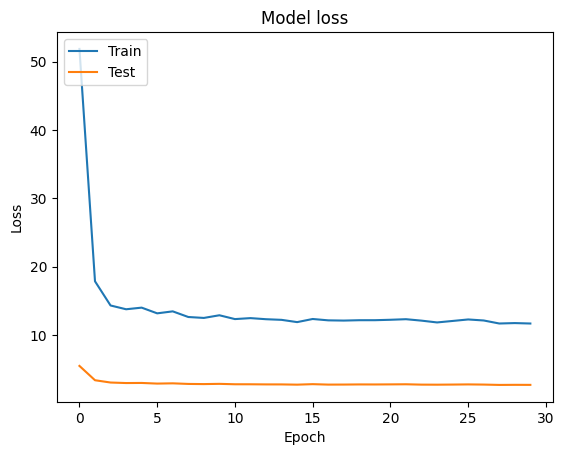

Accuracy: 0.09554140127388536
Precision: 0.06412037906398808
Recall: 0.07750701587170511
F1-Score: 0.06608482114341992
Cohen Kappa Score: 0.5515287024181561
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_74 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_75 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_37 (Gl  (None, 128)             

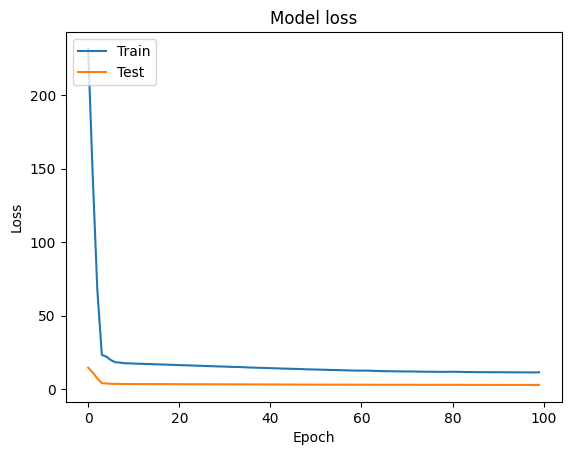

Accuracy: 0.07643312101910828
Precision: 0.028999949522142954
Recall: 0.055016906037632374
F1-Score: 0.035003515681865674
Cohen Kappa Score: 0.48889993081694627

-----------------------Logistic Regression-----------------------
Accuracy: 0.12420382165605096
Precision: 0.13766025059344564
Recall: 0.10539121330442996
F1-Score: 0.09534253351109293
Cohen Kappa Score: 0.6636935932216728


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.11464968152866242
Precision: 0.10862193362193362
Recall: 0.11205726164273486
F1-Score: 0.08785261975829997
Cohen Kappa Score: 0.5591497509699461


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.15605095541401273
Precision: 0.015873545679954224
Recall: 0.07955082742316785
F1-Score: 0.026436781609195402
Cohen Kappa Score: 0.38638868435315954


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.1178343949044586
Precision: 0.09057533433362715
Recall: 0.09794184565041916

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


-----------------------LSTM-----------------------


Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_140 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_141 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1513 (Dropout)      (None, 128)               0         
                                                                 
 dense_108 (Dense)           (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 6s 28ms/step - loss: 107.7215 - mae: 8.7505
Epoch 2/30
10/10 [==============================] - 0s 33ms/step - loss: 31.288

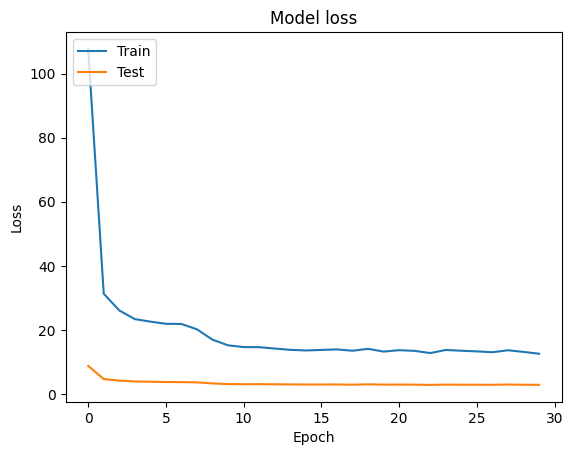

Accuracy: 0.10223642172523961
Precision: 0.03697406929114246
Recall: 0.05789199455866124
F1-Score: 0.03874111306156652
Cohen Kappa Score: 0.40491722816367437
-----------------------BiLSTM-----------------------


Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_70 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_71 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1514 (Dropout)      (None, 200)               0         
                                                                 
 dense_109 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [=========================

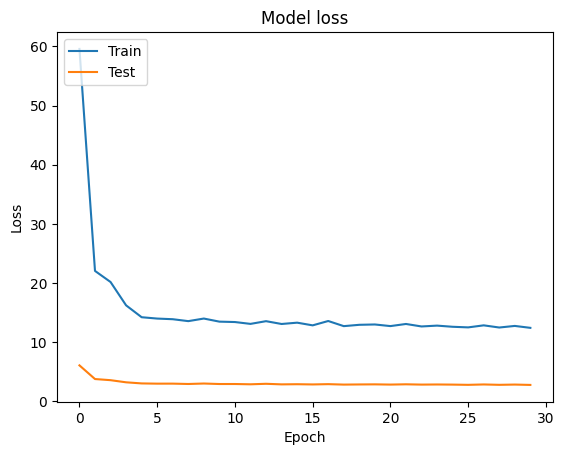

Accuracy: 0.11182108626198083
Precision: 0.04464743538535677
Recall: 0.06474051974051974
F1-Score: 0.04585848134563182
Cohen Kappa Score: 0.4409484041488325
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_76 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_77 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_38 (Gl  (None, 128)             

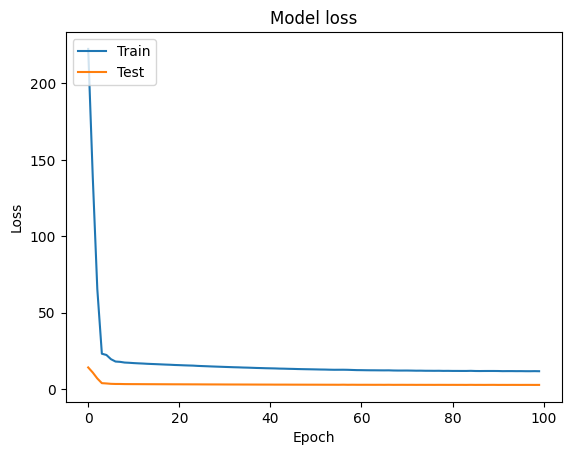

Accuracy: 0.10223642172523961
Precision: 0.027928997686030934
Recall: 0.0618024018024018
F1-Score: 0.03710491561240691
Cohen Kappa Score: 0.3581593782977276

-----------------------Logistic Regression-----------------------
Accuracy: 0.13099041533546327
Precision: 0.08460630436647121
Recall: 0.1083982683982684
F1-Score: 0.05392717093104101
Cohen Kappa Score: 0.6006772898287259


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.13738019169329074
Precision: 0.04377868855337695
Recall: 0.09081484081484081
F1-Score: 0.05342585256378359
Cohen Kappa Score: 0.5268104579222331


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.08945686900958466
Precision: 0.008625747188683348
Recall: 0.0719047619047619
F1-Score: 0.015259323322064105
Cohen Kappa Score: 0.4888474084821154


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.13099041533546327
Precision: 0.10485292182550031
Recall: 0.12657794568158715
F1-Sc

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


-----------------------LSTM-----------------------


Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_144 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_145 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1552 (Dropout)      (None, 128)               0         
                                                                 
 dense_111 (Dense)           (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 6s 34ms/step - loss: 1201.4303 - mae: 34.0756
Epoch 2/30
5/5 [==============================] - 0s 28ms/step - loss: 731.3195

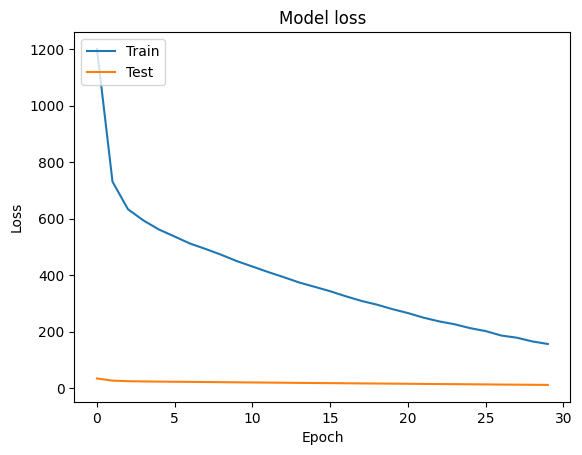

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Cohen Kappa Score: 0.0
-----------------------BiLSTM-----------------------


Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_72 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_73 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1553 (Dropout)      (None, 200)               0         
                                                                 
 dense_112 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [=========================

Accuracy: 0.041379310344827586
Precision: 0.0015915119363395225
Recall: 0.038461538461538464
F1-Score: 0.0030565461029037184
Cohen Kappa Score: 0.0
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_78 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_79 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_39 (Gl  (None, 128)              0       

Accuracy: 0.10344827586206896
Precision: 0.07882064884717403
Recall: 0.06941295883603577
F1-Score: 0.05430259224850929
Cohen Kappa Score: 0.38357609160090655

-----------------------Logistic Regression-----------------------
Accuracy: 0.20689655172413793
Precision: 0.05422222222222222
Recall: 0.0802777777777778
F1-Score: 0.06130751964085298
Cohen Kappa Score: 0.6478168165384259


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.2206896551724138
Precision: 0.022586633663366336
Recall: 0.04599567099567099
F1-Score: 0.029165397502284498
Cohen Kappa Score: 0.5150359810441327


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.27586206896551724
Precision: 0.019907273776879782
Recall: 0.06497668997668998
F1-Score: 0.03046836100134544
Cohen Kappa Score: 0.622848275497605


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.20689655172413793
Precision: 0.07477981788326617
Recall: 0.10837553251346355
F1-S

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


-----------------------LSTM-----------------------


Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_148 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_149 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1591 (Dropout)      (None, 128)               0         
                                                                 
 dense_114 (Dense)           (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 5s 31ms/step - loss: 1208.1956 - mae: 34.1733
Epoch 2/30
5/5 [==============================] - 0s 34ms/step - loss: 775.3414

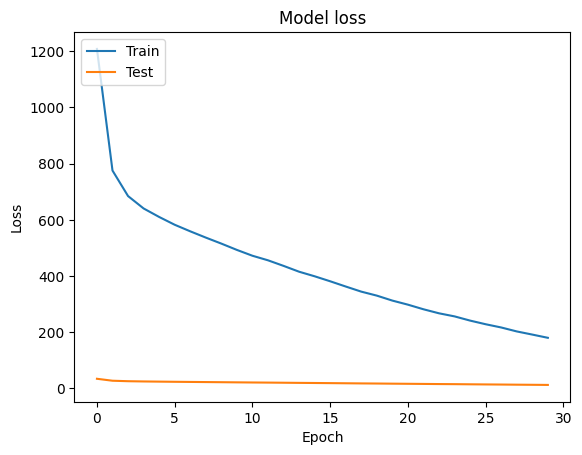

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Cohen Kappa Score: 0.0
-----------------------BiLSTM-----------------------


Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_74 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_75 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1592 (Dropout)      (None, 200)               0         
                                                                 
 dense_115 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [=========================

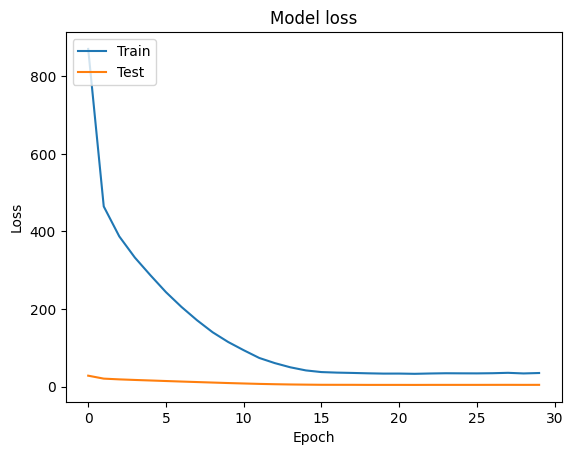

Accuracy: 0.041379310344827586
Precision: 0.0017991004497751124
Recall: 0.043478260869565216
F1-Score: 0.003455226029369421
Cohen Kappa Score: 0.0
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_80 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_81 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_40 (Gl  (None, 128)              0        

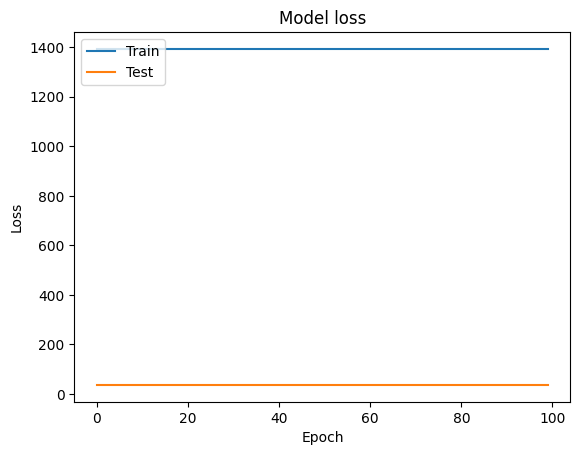

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Cohen Kappa Score: 0.0

-----------------------Logistic Regression-----------------------
Accuracy: 0.15862068965517243
Precision: 0.07644222444222444
Recall: 0.0730489118724413
F1-Score: 0.05660431978823463
Cohen Kappa Score: 0.5366340395437721


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.1793103448275862
Precision: 0.014355742296918767
Recall: 0.05357142857142857
F1-Score: 0.02192252192252192
Cohen Kappa Score: 0.3914321136108354


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.19310344827586207
Precision: 0.015277777777777779
Recall: 0.06547619047619048
F1-Score: 0.0246415770609319
Cohen Kappa Score: 0.45562521896450914


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.15172413793103448
Precision: 0.07271894771894773
Recall: 0.06877413687368439
F1-Score: 0.06271039346041843
Cohen Kappa Score: 0.37787325393151083


-------------

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


-----------------------LSTM-----------------------


Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_152 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_153 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1630 (Dropout)      (None, 128)               0         
                                                                 
 dense_117 (Dense)           (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 6s 37ms/step - loss: 1200.5038 - mae: 34.0329
Epoch 2/30
5/5 [==============================] - 0s 32ms/step - loss: 759.0881

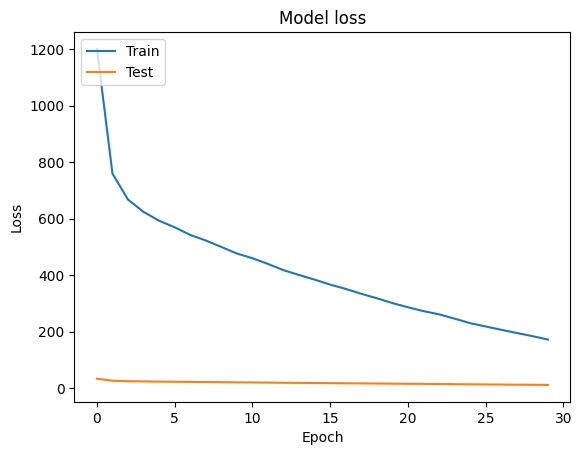

Accuracy: 0.013793103448275862
Precision: 0.0005517241379310345
Recall: 0.04
F1-Score: 0.0010884353741496598
Cohen Kappa Score: 0.0
-----------------------BiLSTM-----------------------


Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_76 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_77 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1631 (Dropout)      (None, 200)               0         
                                                                 
 dense_118 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [=========================

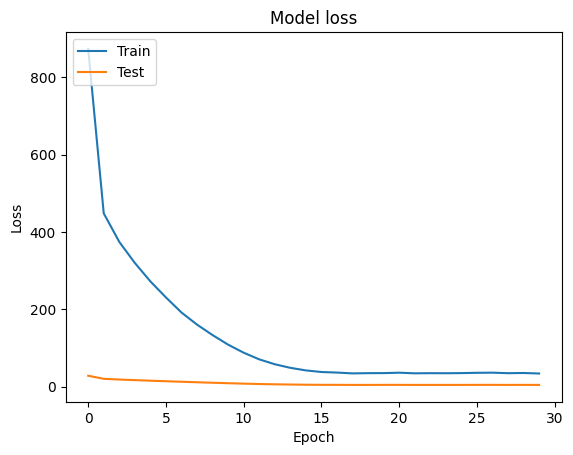

Accuracy: 0.034482758620689655
Precision: 0.001379310344827586
Recall: 0.04
F1-Score: 0.0026666666666666666
Cohen Kappa Score: 0.0
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_82 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_83 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_41 (Gl  (None, 128)              0         
 obalMaxPoolin

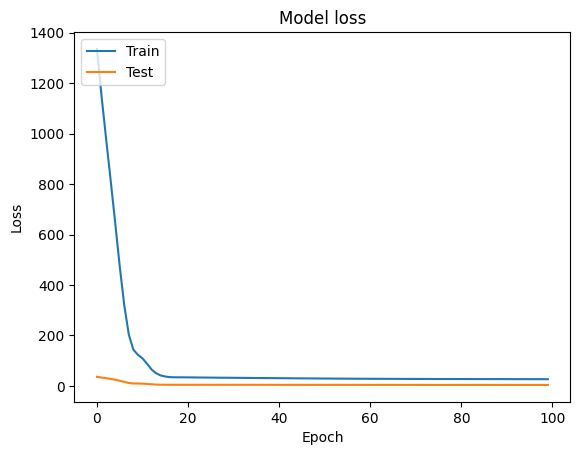

Accuracy: 0.06896551724137931
Precision: 0.03069090909090909
Recall: 0.03417604617604617
F1-Score: 0.028737593984962406
Cohen Kappa Score: 0.29833903181809696

-----------------------Logistic Regression-----------------------
Accuracy: 0.19310344827586207
Precision: 0.08190719455087271
Recall: 0.10012025012025011
F1-Score: 0.08598936585378848
Cohen Kappa Score: 0.5241168315885081


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.2413793103448276
Precision: 0.04966959312753705
Recall: 0.05449350649350649
F1-Score: 0.04147329484616364
Cohen Kappa Score: 0.40694967142241434


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.2413793103448276
Precision: 0.010526315789473684
Recall: 0.04
F1-Score: 0.016666666666666666
Cohen Kappa Score: 0.26924583851070727


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.16551724137931034
Precision: 0.11786433869767202
Recall: 0.1143605365827588
F1-Score: 0.10558

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


-----------------------LSTM-----------------------


Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_156 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_157 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1669 (Dropout)      (None, 128)               0         
                                                                 
 dense_120 (Dense)           (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 7s 35ms/step - loss: 1203.1676 - mae: 34.0824
Epoch 2/30
5/5 [==============================] - 0s 35ms/step - loss: 725.3978

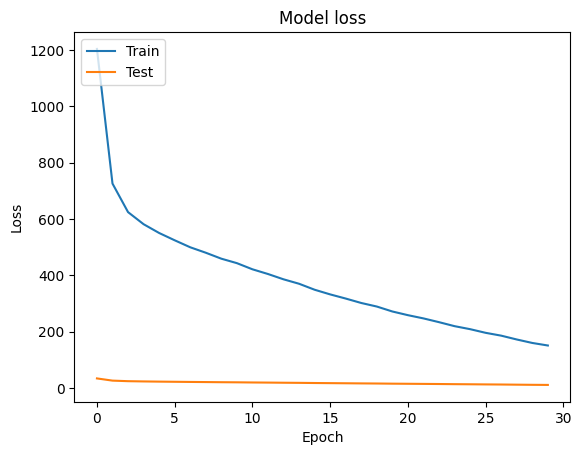

Accuracy: 0.006944444444444444
Precision: 0.00025720164609053495
Recall: 0.037037037037037035
F1-Score: 0.0005108556832694763
Cohen Kappa Score: 0.0
-----------------------BiLSTM-----------------------


Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_78 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_79 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1670 (Dropout)      (None, 200)               0         
                                                                 
 dense_121 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [=========================

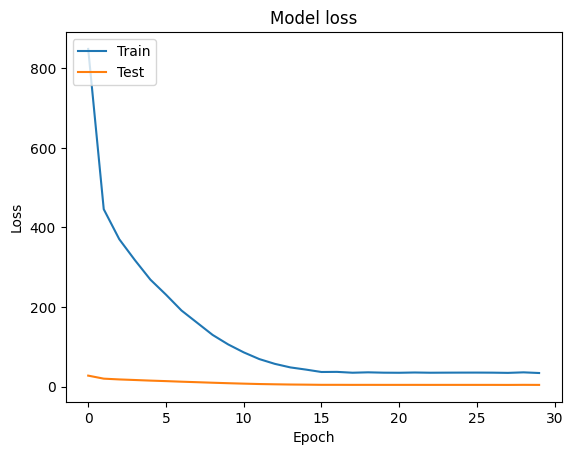

Accuracy: 0.09722222222222222
Precision: 0.00360082304526749
Recall: 0.037037037037037035
F1-Score: 0.006563525550867323
Cohen Kappa Score: 0.0
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_84 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_85 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_42 (Gl  (None, 128)              0         
 

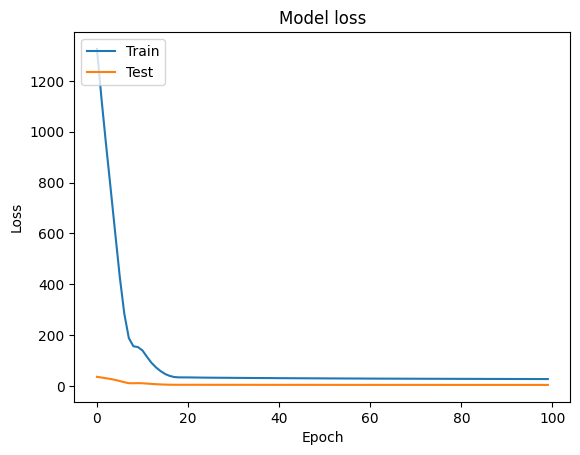

Accuracy: 0.06944444444444445
Precision: 0.019106407995296882
Recall: 0.019089117128332812
F1-Score: 0.01776094276094276
Cohen Kappa Score: 0.3709656485247035

-----------------------Logistic Regression-----------------------
Accuracy: 0.1388888888888889
Precision: 0.08275442588102434
Recall: 0.08401610644257704
F1-Score: 0.07763492772891269
Cohen Kappa Score: 0.598088484661631


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.2152777777777778
Precision: 0.027539291578700446
Recall: 0.04744196529186387
F1-Score: 0.030759437418177018
Cohen Kappa Score: 0.49267571562961965


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.24305555555555555
Precision: 0.027624155075135468
Recall: 0.08920358266763496
F1-Score: 0.04202977487291212
Cohen Kappa Score: 0.5423480270174192


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.1875
Precision: 0.09934274414252169
Recall: 0.07338533114395183
F1-Score: 0.076

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


-----------------------LSTM-----------------------


Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_160 (LSTM)             (None, 1, 400)            1870400   
                                                                 
 lstm_161 (LSTM)             (None, 128)               270848    
                                                                 
 dropout_1708 (Dropout)      (None, 128)               0         
                                                                 
 dense_123 (Dense)           (None, 1)                 129       
                                                                 
Total params: 2,141,377
Trainable params: 2,141,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 5s 38ms/step - loss: 1193.0400 - mae: 33.9296
Epoch 2/30
5/5 [==============================] - 0s 42ms/step - loss: 739.1179

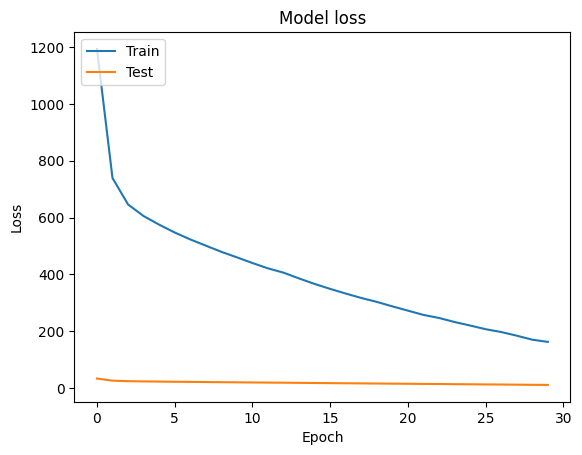

Accuracy: 0.006944444444444444
Precision: 0.00026709401709401707
Recall: 0.038461538461538464
F1-Score: 0.0005305039787798408
Cohen Kappa Score: 0.0
-----------------------BiLSTM-----------------------


Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_80 (Bidirecti  (None, 1, 600)           2565600   
 onal)                                                           
                                                                 
 bidirectional_81 (Bidirecti  (None, 200)              560800    
 onal)                                                           
                                                                 
 dropout_1709 (Dropout)      (None, 200)               0         
                                                                 
 dense_124 (Dense)           (None, 1)                 201       
                                                                 
Total params: 3,126,601
Trainable params: 3,126,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [=========================

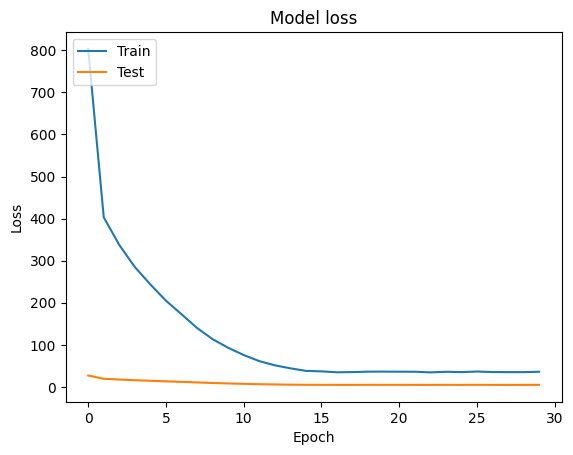

Accuracy: 0.05555555555555555
Precision: 0.0021367521367521365
Recall: 0.038461538461538464
F1-Score: 0.004048582995951417
Cohen Kappa Score: 0.0
-----------------------CNN-----------------------
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 768, 1)]          0         
                                                                 
 conv1d_86 (Conv1D)          (None, 768, 64)           256       
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 384, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_87 (Conv1D)          (None, 384, 128)          24704     
                                                                 
 global_max_pooling1d_43 (Gl  (None, 128)              0         

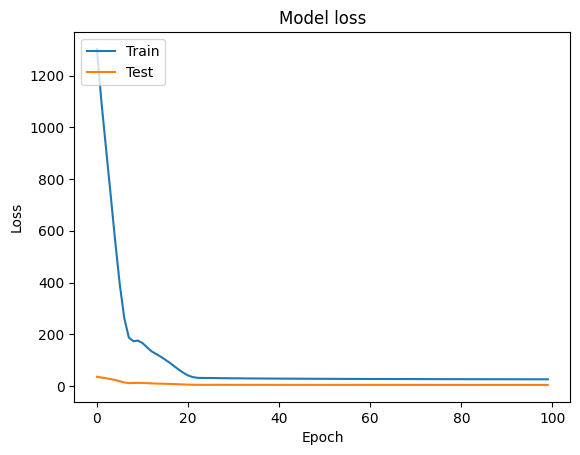

Accuracy: 0.0625
Precision: 0.02538378489465446
Recall: 0.05435945633314054
F1-Score: 0.025340922693863874
Cohen Kappa Score: 0.3341498371335505

-----------------------Logistic Regression-----------------------
Accuracy: 0.1597222222222222
Precision: 0.04873447114826425
Recall: 0.043068486262678646
F1-Score: 0.043830587259996154
Cohen Kappa Score: 0.5128872674374974


-----------------------Random Forest Classifier-----------------------
Accuracy: 0.24305555555555555
Precision: 0.03854372123602893
Recall: 0.055770545244229454
F1-Score: 0.0424808376313393
Cohen Kappa Score: 0.45491301657154637


-----------------------Adaboost Classifier-----------------------
Accuracy: 0.22916666666666666
Precision: 0.015374533723157576
Recall: 0.04825174825174826
F1-Score: 0.023318468970642884
Cohen Kappa Score: 0.38899275077608575


-----------------------K Neibhors Classifier-----------------------
Accuracy: 0.16666666666666666
Precision: 0.07439960832817975
Recall: 0.07918843374670441
F1-Score: 0.

In [53]:
final_lstm=[]
final_bilstm=[]
final_cnn=[]
final_logistic_reg=[]
final_random_forest=[]
final_adaboost=[]
final_k_neighbors=[]
final_svc=[]
for sets in range(1,9):
  df_essay_set = df[df.essay_set == sets]
  X, y = dataset_preparation(df_essay_set)
  # X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 101, test_size = 0.2,)
  print(" -------------------------------------------------")
  print(" -------------------------------------------------")
  print("\n--------SET {}--------\n".format(sets))
  print(" -------------------------------------------------")
  print(" -------------------------------------------------")
  
  start_time = time.time()

  cv = KFold(n_splits=5, shuffle=True)
  cv_data = cv.split(X)
  fold_count =1

  lstm= [-2 for _ in range(5)]
  bilstm= [-2 for _ in range(5)]
  cnn= [-2 for _ in range(5)]
  logistic_reg= [-2 for _ in range(5)]
  random_forest= [-2 for _ in range(5)]
  adaboost= [-2 for _ in range(5)]
  k_neighbors= [-2 for _ in range(5)]
  svc= [-2 for _ in range(5)]


  for traincv, testcv in cv_data:
    print("\n--------Fold {}--------\n".format(fold_count))
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]

    BATCH_SIZE = 16
    MAX_LENGTH = 300

    train_encodings = tokenizer(list(X_train['preprocessed_text']), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(BATCH_SIZE)

    test_encodings = tokenizer(list(X_test['preprocessed_text']), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
    test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(BATCH_SIZE)

    embeddings_train = []
    for batch in tqdm(train_dataset):
        embeddings_train.append(bert_model(batch[0]['input_ids'])[0][:, -1, :])
    embeddings_train = tf.concat(embeddings_train, axis=0)

    embeddings_test = []
    for batch in tqdm(test_dataset):
        embeddings_test.append(bert_model(batch[0]['input_ids'])[0][:, -1, :])
    embeddings_test = tf.concat(embeddings_test, axis=0)

    temp_lstm=[]
    temp_bilstm=[]
    temp_cnn=[]
    temp_logistic_reg=[]
    temp_random_forest=[]
    temp_adaboost=[]
    temp_k_neighbors=[]
    temp_svc=[]

    #LSTM (N,1,L)
    print("-----------------------LSTM-----------------------")

    trainDataVectors=tf.reshape(embeddings_train,[embeddings_train.shape[0],1,embeddings_train.shape[1]])
    testDataVectors=tf.reshape(embeddings_test,[embeddings_test.shape[0],1,embeddings_test.shape[1]]) 
    lstm_model = get_model(bidirectional=False)
    history= lstm_model.fit(trainDataVectors, y_train, batch_size=128, epochs=30)
    y_pred = lstm_model.predict(testDataVectors)
    y_pred = np.around(y_pred)
    np.nan_to_num(y_pred)
    plot_accuracy_curve(history)
    temp_lstm =list(print_metrics_function(y_test, y_pred))
    lstm= max_list(lstm, temp_lstm)
    
    
    #BiLSTM
    print("-----------------------BiLSTM-----------------------")

    Hidden_dim1=300
    Hidden_dim2=100
    return_sequences = True
    dropout=0.2
    recurrent_dropout=0.2
    input_size=768
    activation='relu'
    bidirectional = True
    batch_size = 64
    epoch = 30
    lstm_model = get_model(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                                dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                                activation=activation, bidirectional=bidirectional)
    history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
    y_pred = lstm_model.predict(testDataVectors)
    y_pred = np.around(y_pred)
    np.nan_to_num(y_pred)
    plot_accuracy_curve(history)
    temp_bilstm =list(print_metrics_function(y_test, y_pred))
    bilstm= max_list(bilstm, temp_bilstm)
    

    #CNN
    print("-----------------------CNN-----------------------")

    trainDataVectors_=tf.reshape(trainDataVectors,[trainDataVectors.shape[0],trainDataVectors.shape[2],1])
    testDataVectors_=tf.reshape(testDataVectors,[testDataVectors.shape[0],testDataVectors.shape[2],1])  
    cnn_model = get_model_CNN(output_dims=1)
    history=cnn_model.fit(trainDataVectors_, y_train, batch_size=128, epochs=100)
    y_pred = cnn_model.predict(testDataVectors_)
    y_pred = np.around(y_pred)
    np.nan_to_num(y_pred)
    plot_accuracy_curve(history)
    temp_cnn =list(print_metrics_function(y_test, y_pred))
    cnn= max_list(cnn, temp_cnn)
    
    #New features from feature engineering

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.drop(['preprocessed_text'], axis = 1))
    X_test_scaled = scaler.transform(X_test.drop(['preprocessed_text'], axis = 1))
    X_train_features = tf.constant(X_train_scaled.astype('float32'))
    X_test_features = tf.constant(X_test_scaled.astype('float32'))

    embeddings_train = tf.concat([embeddings_train, X_train_features], axis = 1)
    embeddings_test = tf.concat([embeddings_test, X_test_features], axis = 1)
    print()
    print("-----------------------Logistic Regression-----------------------")
    model = choose_classifiers("logistic_regression")
    model.fit(embeddings_train, y_train)
    y_predictions = model.predict(embeddings_test)
    temp_logistic_reg =list(print_metrics_function(y_test, y_predictions))
    logistic_reg= max_list(logistic_reg, temp_logistic_reg)

    print("\n")
    print("-----------------------Random Forest Classifier-----------------------")
    model = choose_classifiers("random_forest_classifier")
    model.fit(embeddings_train, y_train)
    y_predictions = model.predict(embeddings_test)
    temp_random_forest =list(print_metrics_function(y_test, y_predictions))
    random_forest= max_list(random_forest, temp_random_forest)
    
    print("\n")
    print("-----------------------Adaboost Classifier-----------------------")
    model = choose_classifiers("adaboost_classifier")
    model.fit(embeddings_train, y_train)
    y_predictions = model.predict(embeddings_test)
    temp_adaboost =list(print_metrics_function(y_test, y_predictions))
    adaboost= max_list(adaboost, temp_adaboost)
    

    print("\n")
    print("-----------------------K Neibhors Classifier-----------------------")
    model = choose_classifiers("k_neighbors_classifier")
    model.fit(embeddings_train, y_train)
    y_predictions = model.predict(embeddings_test)
    temp_k_neighbors =list(print_metrics_function(y_test, y_predictions))
    k_neighbors= max_list(k_neighbors, temp_k_neighbors)
    

    print("\n")
    print("-----------------------Support Vector Classifier-----------------------")
    model = choose_classifiers("support_vector_classifier")
    model.fit(embeddings_train, y_train)
    y_predictions = model.predict(embeddings_test)
    temp_svc =list(print_metrics_function(y_test, y_predictions))
    svc= max_list(svc, temp_svc)

    fold_count+=1

  end_time = time.time()
  time_taken = end_time - start_time

  print("Time taken: {:.5f} seconds".format(time_taken))

  
  # Define the metric names and their corresponding values
  metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "Kappa Score"]

  metrics_list=[lstm, bilstm, cnn, logistic_reg, random_forest, adaboost, k_neighbors, svc]
  # Define the ML model names
  model_names = ["LSTM","BiLSTM","CNN","Logistic Regression", "Random Forest Classifier", "Adaboost Classifier", 
                "K Neighbors Classifier", "Support Vector Classifier"]

  # Create a PrettyTable object with the metric names as column headers
  table = PrettyTable(["Model"] + metric_names)

  # Add the metric values for each model as rows to the table
  for i, model_name in enumerate(model_names):
      row = [model_name]
      for j in range(len(metric_names)):
          value = metrics_list[i][j]

          # Format the value with three decimal places
          value_formatted = f"{value:.3f}"
          row.append(value_formatted)

      table.add_row(row)

  # Print the formatted table
  print(table.get_string())
  final_lstm.append(lstm[4])
  final_bilstm.append(bilstm[4])
  final_cnn.append(cnn[4])
  final_logistic_reg.append(logistic_reg[4])
  final_random_forest.append(random_forest[4])
  final_adaboost.append(adaboost[4])
  final_k_neighbors.append(k_neighbors[4])
  final_svc.append(svc[4])




In [54]:
# Define the metric names and their corresponding values
metric_names = ["Prompt-1","Prompt-2","Prompt-3","Prompt-4","Prompt-5","Prompt-6","Prompt-7","Prompt-8"]

metrics_list=[final_lstm, final_bilstm, final_cnn, final_logistic_reg, final_random_forest, final_adaboost, final_k_neighbors, final_svc]
# Define the ML model names
model_names = ["LSTM","BiLSTM","CNN","Logistic Regression", "Random Forest Classifier", "Adaboost Classifier", 
              "K Neighbors Classifier", "Support Vector Classifier"]

table = PrettyTable(["Model"] + metric_names)

  # Add the metric values for each model as rows to the table
for i, model_name in enumerate(model_names):
    row = [model_name]
    for j in range(len(metric_names)):
        value = metrics_list[i][j]

        # Format the value with three decimal places
        value_formatted = f"{value:.3f}"
        row.append(value_formatted)

    table.add_row(row)

# Print the formatted table
print(table.get_string())


+---------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
|           Model           | Prompt-1 | Prompt-2 | Prompt-3 | Prompt-4 | Prompt-5 | Prompt-6 | Prompt-7 | Prompt-8 |
+---------------------------+----------+----------+----------+----------+----------+----------+----------+----------+
|            LSTM           |  0.807   |  0.673   |  0.543   |  0.689   |  0.618   |  0.634   |  0.610   |  0.000   |
|           BiLSTM          |  0.807   |  0.646   |  0.595   |  0.707   |  0.675   |  0.652   |  0.562   |  0.000   |
|            CNN            |  0.779   |  0.649   |  0.243   |  0.533   |  0.567   |  0.000   |  0.489   |  0.384   |
|    Logistic Regression    |  0.798   |  0.698   |  0.630   |  0.586   |  0.767   |  0.687   |  0.664   |  0.648   |
|  Random Forest Classifier |  0.785   |  0.684   |  0.461   |  0.633   |  0.612   |  0.613   |  0.559   |  0.515   |
|    Adaboost Classifier    |  0.642   |  0.643   |  0.5